Code Block 1: Setup, Instance Generation, Model Definition

In [2]:
# -*- coding: utf-8 -*-
# Block 1: Setup, Instance Generation (Strict Table 2 Alignment), Model Definition, Plotting

import gurobipy as gp
from gurobipy import GRB
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print(f"Gurobi Optimizer version: {gp.gurobi.version()}")

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# --- Instance Generation (Strictly Adhering to Table 2 and Derived Sets) ---
def generate_instance_table2_final(num_stores, num_physical_satellites, num_products, num_orders,
                                   vehicle_capacity_V_star, penalty_pu_param, split_ps_param,
                                   seed=42, vehicle_buffer=0): # Default vehicle_buffer to 0, can be adjusted
    random.seed(seed)

    # --- SET DEFINITIONS (as per LaTeX derived from Table 2) ---
    depot_node_0 = 'D0' # Represents node '0'

    set_S_stores = [f"S{s_idx+1}" for s_idx in range(num_stores)]

    # M_T2 (Table 2's M): satellites where 0 denotes the central warehouse
    _physical_sat_nodes_temp = [f"M{m_idx+1}" for m_idx in range(num_physical_satellites)]
    set_M_T2_sats_and_depot = [depot_node_0] + _physical_sat_nodes_temp # This is M in Table 2

    # M_phys = M_T2 \ {0} : Physical satellite locations ONLY
    set_M_phys_physical_satellites = _physical_sat_nodes_temp

    # N_cust = S U M_phys : All CUSTOMER nodes (stores + physical satellites)
    set_N_cust_all_customers = set_S_stores + set_M_phys_physical_satellites

    # N_all = S U M_T2 : All NODES in network (stores + physical satellites + depot)
    set_N_all_network_nodes = list(set(set_S_stores + set_M_T2_sats_and_depot))

    # L_arcs: (i,j) in N_all x N_all, i != j
    set_L_arcs = [(i, j) for i in set_N_all_network_nodes for j in set_N_all_network_nodes if i != j]

    set_R_product_types = [f"P{r_idx+1}" for r_idx in range(num_products)]
    set_B_order_types = [f"B{b_idx+1}" for b_idx in range(num_orders)]

    # --- PARAMETERS ---
    param_coords = {depot_node_0: (0, 0)}
    for i_node in set_S_stores: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25)) # Smaller range
    for i_node in set_M_phys_physical_satellites: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25))

    param_d_ij_dist = {}; param_t_ij_time = {}; max_travel_t_val = 0
    for i_node, j_node in set_L_arcs:
        dist_val = euclidean_distance(param_coords[i_node], param_coords[j_node])
        param_d_ij_dist[i_node, j_node] = dist_val
        param_t_ij_time[i_node, j_node] = dist_val # Assuming speed = 1
        max_travel_t_val = max(max_travel_t_val, param_t_ij_time[i_node, j_node])
    for i_node in set_N_all_network_nodes : param_d_ij_dist[i_node,i_node]=0; param_t_ij_time[i_node,i_node]=0

    param_o_i_service = {node: 0 for node in set_N_all_network_nodes} # o_0 = 0 for depot
    total_serv_t_val = 0
    for node_cust in set_N_cust_all_customers:
        param_o_i_service[node_cust] = random.uniform(3, 10) # Smaller service times
        total_serv_t_val += param_o_i_service[node_cust]

    param_V_r_volume = {r_prod: random.randint(1, 3) for r_prod in set_R_product_types} # V_r
    param_V_b_volume = {b_ord: random.randint(1, 3) for b_ord in set_B_order_types} # V_b

    param_D_i_r_S_demand = {}; total_vol_demand_S = 0 # D_i^r (store i, product r)
    for j_store in set_S_stores:
        for r_prod in set_R_product_types:
            demand_val = random.randint(3, 10)
            param_D_i_r_S_demand[j_store, r_prod] = demand_val
            total_vol_demand_S += param_V_r_volume[r_prod] * demand_val

    param_D_i_b_Mphys_demand = {}; total_vol_demand_M_phys = 0 # D_i^b (satellite i, order b)
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            demand_val = random.randint(3, 10)
            param_D_i_b_Mphys_demand[j_sat_phys, b_ord] = demand_val
            total_vol_demand_M_phys += param_V_b_volume[b_ord] * demand_val

    total_overall_demand_vol = total_vol_demand_S + total_vol_demand_M_phys

    param_l_i_deadline = {} # l_i
    max_deadln_val = 0
    for node_cust in set_N_cust_all_customers:
        min_req_t = param_t_ij_time.get((depot_node_0, node_cust), float('inf')) + param_o_i_service.get(node_cust, 0)
        base_deadln_val = min_req_t + random.uniform(15, 50) # Tighter deadlines
        param_l_i_deadline[node_cust] = max(min_req_t + 0.1, base_deadln_val) # Ensure feasible by a small margin
        max_deadln_val = max(max_deadln_val, param_l_i_deadline[node_cust])
    param_l_i_deadline[depot_node_0] = max_deadln_val + max_travel_t_val + total_serv_t_val # Deadline for depot for Big-M

    # Fleet size VF based on Paper Eq. (1)
    numerator_eq1 = 0
    for r_prod in set_R_product_types:
        for j_store in set_S_stores:
            numerator_eq1 += param_V_r_volume[r_prod] * param_D_i_r_S_demand.get((j_store, r_prod), 0)
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            numerator_eq1 += param_V_b_volume[b_ord] * param_D_i_b_Mphys_demand.get((j_sat_phys, b_ord), 0)
    
    min_vehicles_eq1_val = 0
    if vehicle_capacity_V_star > 0:
        min_vehicles_eq1_val = math.ceil(numerator_eq1 / vehicle_capacity_V_star)
    else: # Fallback if V_star is 0 or negative
        min_vehicles_eq1_val = len(set_N_cust_all_customers) # Ensure at least one vehicle per customer if capacity is weird
        print(f"Warning: vehicle_capacity_V_star is {vehicle_capacity_V_star}. Using fallback for min_vehicles_eq1_val.")


    num_vehicles_in_fleet = int(min_vehicles_eq1_val + vehicle_buffer)
    set_VF_fleet = [f"K{k_idx+1}" for k_idx in range(num_vehicles_in_fleet)]

    param_M_TIME_for_big_M = param_l_i_deadline[depot_node_0] * 1.5 # Ensure it's large enough

    instance_data = {
        "S_stores": set_S_stores, "M_T2_sats_and_depot": set_M_T2_sats_and_depot,
        "M_phys_satellites": set_M_phys_physical_satellites, "N_cust_customers": set_N_cust_all_customers,
        "N_all_network_nodes": set_N_all_network_nodes, "L_arcs": set_L_arcs,
        "depot_node": depot_node_0, "R_product_types": set_R_product_types,
        "B_order_types": set_B_order_types, "VF_fleet": set_VF_fleet,
        "coords": param_coords, "d_ij": param_d_ij_dist, "t_ij": param_t_ij_time, # Renamed t_ij_travel to t_ij
        "o_i": param_o_i_service, "V_r": param_V_r_volume, # Renamed v_r_volume to V_r
        "V_b": param_V_b_volume, "D_i_r": param_D_i_r_S_demand, # Renamed D_jr_S_demand to D_i_r
        "D_i_b": param_D_i_b_Mphys_demand, "l_i": param_l_i_deadline, # Renamed l_j_deadline to l_i
        "V_star": vehicle_capacity_V_star, "p_u": penalty_pu_param, # Renamed
        "p_s": split_ps_param, "M_TIME_BIG": param_M_TIME_for_big_M, # Renamed
        "total_demand_vol_overall": total_overall_demand_vol, "min_vehicles_eq1": min_vehicles_eq1_val,
        "vehicle_buffer": vehicle_buffer # Store buffer for sensitivity
    }
    return instance_data

# --- VRPOR Model Building Function (Strict Table 2 Alignment) ---
def solve_vrpor_table2_final(instance, time_limit=60, mip_gap=0.001, log_to_console=0):
    S = instance["S_stores"]; M_T2 = instance["M_T2_sats_and_depot"]; M_phys = instance["M_phys_satellites"]
    N_cust = instance["N_cust_customers"]; N_all = instance["N_all_network_nodes"]
    L_arcs_set = instance["L_arcs"]; depot = instance["depot_node"]
    R_set = instance["R_product_types"]; B_set = instance["B_order_types"]; VF_set = instance["VF_fleet"]
    d_ij = instance["d_ij"]; t_ij = instance["t_ij"]; o_i = instance["o_i"]
    V_r = instance["V_r"]; V_b = instance["V_b"]; D_i_r = instance["D_i_r"] # Demands for stores
    D_i_b = instance["D_i_b"]; l_i = instance["l_i"]; V_star = instance["V_star"] # Demands for satellites
    p_u = instance["p_u"]; p_s = instance["p_s"]; M_BIG = instance["M_TIME_BIG"]

    model = gp.Model("VRPOR_Table2_StrictFinal_Improved")
    model.Params.LogToConsole = log_to_console
    model.Params.TimeLimit = time_limit; model.Params.MIPGap = mip_gap; model.Params.NonConvex = 2

    # --- Decision Variables (as per LaTeX Table 2) ---
    x = model.addVars(L_arcs_set, VF_set, vtype=GRB.BINARY, name="x") # x_ij^k
    Q = model.addVars(S, VF_set, R_set, vtype=GRB.INTEGER, lb=0.0, name="Q") # Q_j^kr (j in S)
    Y = model.addVars(M_phys, VF_set, B_set, vtype=GRB.INTEGER, lb=0.0, name="Y") # Y_j^kb (j in M_phys)
    t_arrival = model.addVars(N_all, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_k_j") # t_j^k (all nodes for consistency with Eq12)

    # --- Auxiliary Variables for Objective ---
    # For (t_j^k - l_j)^+ part of penalty term
    t_minus_l_positive = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_minus_l_pos")
    # For sum_{b in B} V_b Y_j^kb part of penalty term
    volume_Y_jk = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="vol_Y_jk")
    # For ((sum_k sum_i x_ij^k) - 1)^+ part of split cost
    total_arrivals_at_j = model.addVars(N_cust, vtype=GRB.INTEGER, lb=0.0, name="total_arrivals_j")
    extra_arrivals_at_j_positive = model.addVars(N_cust, vtype=GRB.CONTINUOUS, lb=0.0, name="extra_arrivals_j_pos")
    
    zero_var = model.addVar(lb=0.0, ub=0.0, name="zero_constant_for_max") # Helper for max(A,0)

    # --- Objective Function (Eq. 2 from LaTeX) ---
    term1_travel_cost = gp.quicksum(d_ij[i_node,j_node] * x[i_node,j_node,k_veh]
                                   for (i_node,j_node) in L_arcs_set for k_veh in VF_set)

    # Define auxiliary variables for bi-linear term
    for j_sat in M_phys:
        for k_veh in VF_set:
            model.addConstr(t_minus_l_positive[j_sat, k_veh] >= t_arrival[j_sat, k_veh] - l_i[j_sat], name=f"def_t_minus_l_pos_{j_sat}_{k_veh}")
            model.addConstr(volume_Y_jk[j_sat, k_veh] == gp.quicksum(V_b[b_ord] * Y[j_sat, k_veh, b_ord]
                                                                    for b_ord in B_set if (j_sat,k_veh,b_ord) in Y), name=f"def_vol_Y_{j_sat}_{k_veh}")
    term2_penalty_cost = gp.quicksum(p_u * t_minus_l_positive[j_sat, k_veh] * volume_Y_jk[j_sat, k_veh]
                                      for j_sat in M_phys for k_veh in VF_set)

    # Define auxiliary variables for split cost term
    for j_node_cust in N_cust:
        model.addConstr(total_arrivals_at_j[j_node_cust] == gp.quicksum(x[i_node, j_node_cust, k_veh]
                                                                    for (i_node, _j) in L_arcs_set if _j == j_node_cust # Sum over i for fixed j
                                                                    for k_veh in VF_set), name=f"def_total_arrivals_{j_node_cust}")
        # (A - 1)+ = max(A-1, 0)
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= total_arrivals_at_j[j_node_cust] - 1, name=f"def_extra_arr_ge_m1_{j_node_cust}")
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= zero_var, name=f"def_extra_arr_ge_0_{j_node_cust}") # Ensures positive for max
        # Gurobi's max_ function can also be used if preferred: model.addConstr(extra_arrivals_at_j_positive[j_node_cust] == gp.max_(total_arrivals_at_j[j_node_cust] - 1, zero_var), name=f"def_extra_arrivals_max_{j_node_cust}")

    term3_split_cost = p_s * gp.quicksum(extra_arrivals_at_j_positive[j_node_cust] for j_node_cust in N_cust)

    model.setObjective(term1_travel_cost + term2_penalty_cost + term3_split_cost, GRB.MINIMIZE)

    # --- Constraints (Eqs. 3-16 from LaTeX) ---
    # Eq. 3
    model.addConstr(gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set for k_veh in VF_set) <= len(VF_set), "PaperEq3_TotalDepartures")

    # Eq. 4
    for k_veh in VF_set:
        sum_out_depot = gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set)
        sum_in_depot  = gp.quicksum(x[i_node_cust,depot,k_veh] for i_node_cust in N_cust if (i_node_cust,depot) in L_arcs_set)
        model.addConstr(sum_out_depot == sum_in_depot, f"PaperEq4_ReturnToDepot_{k_veh}")
        model.addConstr(sum_out_depot <= 1, f"PaperEq4_DepartDepotOnce_{k_veh}")

    # Eq. 5
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            model.addConstr(gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust) <= 1, f"PaperEq5_VisitCustOncePerVeh_{k_veh}_{j_node_cust}")

    # Eq. 6
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            inflow_j = gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust)
            outflow_j = gp.quicksum(x[j_node_cust,l_node,k_veh] for l_node in N_all if (j_node_cust,l_node) in L_arcs_set and l_node != j_node_cust)
            model.addConstr(inflow_j - outflow_j == 0, f"PaperEq6_FlowConservation_{k_veh}_{j_node_cust}")

    # Eq. 7
    for j_store in S:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_store, k_veh] for i_node in N_all if (i_node, j_store) in L_arcs_set and i_node != j_store)
            for r_prod in R_set:
                if (j_store, r_prod) in D_i_r: # Check if demand exists
                     model.addConstr(Q[j_store, k_veh, r_prod] <= D_i_r[j_store, r_prod] * vehicle_visits_j, f"PaperEq7_LinkQtoX_{j_store}_{k_veh}_{r_prod}")

    # Eq. 8
    for j_sat in M_phys:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_sat, k_veh] for i_node in N_all if (i_node, j_sat) in L_arcs_set and i_node != j_sat)
            for b_ord in B_set:
                 if (j_sat, b_ord) in D_i_b: # Check if demand exists
                    model.addConstr(Y[j_sat, k_veh, b_ord] <= D_i_b[j_sat, b_ord] * vehicle_visits_j, f"PaperEq8_LinkYtoX_{j_sat}_{k_veh}_{b_ord}")

    # Eq. 9
    for k_veh in VF_set:
        volume_products_Q = gp.quicksum(V_r[r_prod] * Q[j_store,k_veh,r_prod] for j_store in S for r_prod in R_set if (j_store,k_veh,r_prod) in Q)
        volume_orders_Y = gp.quicksum(V_b[b_ord] * Y[j_sat,k_veh,b_ord] for j_sat in M_phys for b_ord in B_set if (j_sat,k_veh,b_ord) in Y)
        model.addConstr(volume_products_Q + volume_orders_Y <= V_star, f"PaperEq9_VehicleCapacity_{k_veh}")

    # Eq. 10
    for j_store in S:
        for r_prod in R_set:
            if (j_store, r_prod) in D_i_r: # Check if demand exists
                model.addConstr(gp.quicksum(Q[j_store,k_veh,r_prod] for k_veh in VF_set if (j_store,k_veh,r_prod) in Q) == D_i_r[j_store,r_prod], f"PaperEq10_DemandSat_S_{j_store}_{r_prod}")

    # Eq. 11
    for j_sat in M_phys:
        for b_ord in B_set:
             if (j_sat, b_ord) in D_i_b: # Check if demand exists
                model.addConstr(gp.quicksum(Y[j_sat,k_veh,b_ord] for k_veh in VF_set if (j_sat,k_veh,b_ord) in Y) == D_i_b[j_sat,b_ord], f"PaperEq11_DemandSat_Mphys_{j_sat}_{b_ord}")

    # Eq. 12 (Time propagation with Big-M)
    model.addConstrs((t_arrival[depot,k_veh] == 0 for k_veh in VF_set), name="TimeAtDepotIsZero_Eq12_base")
    for k_veh in VF_set:
        for j_node_cust in N_cust: # For j in S U M/{0}
            for i_node in N_all: # Sum over i in N_all (S U M in paper)
                if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust :
                     # t_j^k >= t_i^k + o_i + t_ij - M(1-x_ij^k)
                    model.addConstr(t_arrival[j_node_cust,k_veh] >= t_arrival[i_node,k_veh] + o_i.get(i_node,0) + t_ij.get((i_node,j_node_cust),0) - M_BIG*(1-x[i_node,j_node_cust,k_veh]), f"PaperEq12_TimeProp_{k_veh}_{i_node}_{j_node_cust}")

    # Eq. 13 (Hard time window for stores S with Big-M)
    for k_veh in VF_set:
        for j_store in S:
            # t_j^k <= l_j + M(1 - sum_i x_ij^k)
            # sum_i x_ij^k is 1 if store j is visited by vehicle k, 0 otherwise.
            is_visited_by_k = gp.quicksum(x[i_node,j_store,k_veh] for i_node in N_all if (i_node,j_store) in L_arcs_set and i_node != j_store)
            model.addConstr(t_arrival[j_store,k_veh] <= l_i[j_store] + M_BIG*(1-is_visited_by_k), f"PaperEq13_HardTW_S_{k_veh}_{j_store}")
    
    # Eq. 14 (x binary), Eq. 15 (Y integer), Eq. 16 (Q integer) are handled by var definitions.

    # Symmetry Breaking (optional, but can help)
    for k_idx in range(len(VF_set)-1):
        k_curr, k_next = VF_set[k_idx], VF_set[k_idx+1]
        # Force earlier vehicles to be used before later ones
        sum_departs_curr = gp.quicksum(x[depot, jc, k_curr] for jc in N_cust if (depot, jc) in L_arcs_set)
        sum_departs_next = gp.quicksum(x[depot, jc, k_next] for jc in N_cust if (depot, jc) in L_arcs_set)
        model.addConstr(sum_departs_next <= sum_departs_curr, f"SymmetryBreaking_VehOrder_{k_curr}_{k_next}")


    start_time=time.time();model.optimize();end_time=time.time();solve_duration=end_time-start_time
    results={"instance":instance,"model":model,"status_code":model.status,"solve_time":solve_duration,"status_message":{GRB.OPTIMAL:"Optimal",GRB.TIME_LIMIT:"Time Limit Reached",GRB.INTERRUPTED:"Interrupted",GRB.INFEASIBLE:"Infeasible",GRB.UNBOUNDED:"Unbounded",GRB.INF_OR_UNBD:"Infeasible or Unbounded"}.get(model.status,f"Unknown Status ({model.status})")}
    if model.status in [GRB.OPTIMAL,GRB.TIME_LIMIT,GRB.INTERRUPTED] and model.SolCount>0:
        results.update({"objective_value":model.ObjVal,"runtime":model.Runtime,"mip_gap":model.MIPGap,"node_count":model.NodeCount})
        
        sol_x_val={ k_sol_tuple : k_sol_var.X for k_sol_tuple,k_sol_var in x.items() if k_sol_var.X > 0.5 }
        sol_Q_val={k_sol:v.X for k_sol,v in Q.items() if v.X>0.5}
        sol_Y_val={k_sol:v.X for k_sol,v in Y.items() if v.X>0.5}
        sol_t_val={k_sol:v.X for k_sol,v in t_arrival.items()} # Get all arrival times
        
        sol_late_plus_val = {}
        if hasattr(t_minus_l_positive, 'items'): # Check if var was added (e.g. if M_phys is not empty)
            sol_late_plus_val={k_s:v.X for k_s,v in t_minus_l_positive.items() if v.X > 1e-6}
        
        sol_extra_arrivals_val = {}
        if hasattr(extra_arrivals_at_j_positive, 'items'):
             sol_extra_arrivals_val={k_s:v.X for k_s,v in extra_arrivals_at_j_positive.items() if v.X > 0.5} # Should be integer-like

        sol_volY_kj_val = {}
        if hasattr(volume_Y_jk, 'items'):
            sol_volY_kj_val={k_s:v.X for k_s,v in volume_Y_jk.items() if v.X > 1e-4}

        results["solution"]={"x":sol_x_val,"Q":sol_Q_val,"Y":sol_Y_val,"t_arrival":sol_t_val,
                             "lateness_positive_part":sol_late_plus_val,
                             "split_extra_visits_image":sol_extra_arrivals_val,
                             "total_volume_Y_jk_for_penalty":sol_volY_kj_val}


        obj_T_calc=sum(d_ij[i,j]*x_val for (i,j,k),x_val in sol_x_val.items() if (i,j) in d_ij)
        obj_P_calc=sum(p_u*sol_late_plus_val.get((jm,kv),0)*sol_volY_kj_val.get((jm,kv),0) for jm in M_phys for kv in VF_set)
        obj_S_calc=sum(p_s*val for jc,val in sol_extra_arrivals_val.items())
        results["objective_components"]={"travel":obj_T_calc,"penalty":obj_P_calc,"split":obj_S_calc,"calculated_total":obj_T_calc+obj_P_calc+obj_S_calc}

        routes_found={}; cust_served_set=set()
        for k_v_rt in VF_set:
            departs_d = any(sol_x_val.get(((depot,jc,k_v_rt)),0)>0.5 for jc in N_cust if (depot,jc) in L_arcs_set)
            if departs_d:
                rt_k_list=[depot];curr_node_rt=depot;visited_nodes_rt={depot}
                for _ in range(len(N_all)+2): # Max possible nodes + depot return
                    next_node_sel=None
                    # Iterate through L_arcs_set to find outgoing arc for current_node_rt
                    for i_arc_rt, j_arc_rt in L_arcs_set:
                        if i_arc_rt == curr_node_rt and sol_x_val.get(((i_arc_rt,j_arc_rt,k_v_rt)),0)>0.5:
                            # Prefer non-visited node, or depot if it's the only option to close loop
                            if j_arc_rt not in visited_nodes_rt or (j_arc_rt == depot and len(rt_k_list) > 1):
                                next_node_sel=j_arc_rt; break
                    if not next_node_sel: # Could be end of path not at depot, or only visited nodes left
                        if curr_node_rt != depot and (curr_node_rt, depot) in L_arcs_set and sol_x_val.get(((curr_node_rt,depot,k_v_rt)),0)>0.5:
                             if depot not in visited_nodes_rt or len(rt_k_list) > 1 : # Allow returning to depot
                                rt_k_list.append(depot)
                        break
                    rt_k_list.append(next_node_sel)
                    if next_node_sel != depot : visited_nodes_rt.add(next_node_sel) # Don't mark depot as "visited" to allow return
                    if next_node_sel in N_cust:cust_served_set.add(next_node_sel)
                    curr_node_rt=next_node_sel
                    if curr_node_rt==depot and len(rt_k_list)>1 :break # Route ended at depot
                
                # Refined route validation
                if len(rt_k_list)>2 and rt_k_list[0]==depot and rt_k_list[-1]==depot:
                    routes_found[k_v_rt]=rt_k_list
                elif len(rt_k_list)>1 and rt_k_list[0]==depot: # Started from depot but might not have returned
                    # Attempt to add depot if it's the only logical next step
                    final_node = rt_k_list[-1]
                    if final_node != depot and (final_node, depot) in L_arcs_set and sol_x_val.get(((final_node, depot, k_v_rt)), 0) > 0.5:
                        rt_k_list.append(depot)
                        if rt_k_list[0] == depot and rt_k_list[-1] == depot:
                             routes_found[k_v_rt]=rt_k_list
                        else: print(f"Warning: Route {k_v_rt} seems incomplete after trying to close: {rt_k_list}")
                    elif final_node != depot:
                        print(f"Warning: Route {k_v_rt} is incomplete or open: {rt_k_list}")


        results["routes"]=routes_found;results["nodes_served"]=len(cust_served_set)
    else:results.update({"objective_value":None,"runtime":model.Runtime,"mip_gap":None,"node_count":model.NodeCount if hasattr(model,'NodeCount') else None,"solution":None,"routes":None,"nodes_served":0,"objective_components":None})
    return results

# --- Results Printing and Plotting Functions (No change needed in these usually, but check keys) ---
def print_results_summary(results):
    print("\n--- Optimization Summary ---")
    print(f"Status: {results.get('status_message', 'N/A')} (Code: {results.get('status_code', 'N/A')})")
    obj_val = results.get("objective_value")
    if obj_val is not None:
        print(f"Objective Value: {obj_val:.2f}")
        obj_comp = results.get("objective_components")
        if obj_comp: print(f"  Components: Travel={obj_comp['travel']:.2f}, Penalty={obj_comp['penalty']:.2f}, Split={obj_comp['split']:.2f} (Calc Sum: {obj_comp['calculated_total']:.2f})")
        else: print("  Objective components not calculated.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"MIP Gap: {results.get('mip_gap','N/A'):.4f}" if results.get('mip_gap') is not None else "MIP Gap: N/A")
        print(f"Nodes Explored: {results.get('node_count','N/A')}")
        print(f"Nodes Served: {results.get('nodes_served','N/A')} / {len(results['instance']['N_cust_customers'])}")
        routes = results.get("routes"); sol = results.get("solution")
        if routes: print(f"\nRoutes Found ({len(routes)}):"); [print(f"  {k}: {' -> '.join(route)}") for k,route in routes.items()]
        else: print("\nNo valid routes extracted.")
        if sol:
             split_visits_img = sol.get("split_extra_visits_image")
             lateness_pos_part_vals = sol.get("lateness_positive_part")
             if split_visits_img and any(v > 0.5 for v in split_visits_img.values()): print("\nSplit Deliveries (Extra Visits > 0):"); [print(f"  Node {j}: {int(round(extra))} extra visit(s)") for j, extra in split_visits_img.items() if extra > 0.5]
             if lateness_pos_part_vals and any(v > 1e-4 for v in lateness_pos_part_vals.values()): print("\nLate Deliveries at Satellites (Lateness > 0):"); [print(f"  Node {jk[0]} by Veh {jk[1]}: {val:.2f} time units late") for jk, val in lateness_pos_part_vals.items() if val > 1e-4]
    else:
        print("No feasible solution found or optimization failed."); print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s"); print(f"Nodes Explored: {results.get('node_count','N/A')}")
    print("--------------------------\n")

def plot_solution_routes(results):
    instance = results.get("instance"); routes = results.get("routes")
    if not instance or not routes: print("Cannot plot: Missing instance or routes."); return
    coords = instance["coords"]; depot = instance["depot_node"]
    S_nodes = instance["S_stores"]; M_nodes = instance["M_phys_satellites"] # Correct key
    plt.figure(figsize=(12,10)); plt.scatter(coords[depot][0], coords[depot][1], c='black', marker='s', s=150, label=f'Depot ({depot})', zorder=5)
    if S_nodes: plt.scatter(*zip(*[coords[s] for s in S_nodes if s in coords]), c='blue', marker='o', s=80, label='Stores (S)', zorder=5)
    if M_nodes: plt.scatter(*zip(*[coords[m] for m in M_nodes if m in coords]), c='red', marker='^', s=80, label='Satellites (M_phys)', zorder=5) # Correct label
    for node,(x_coord,y_coord) in coords.items(): plt.text(x_coord, y_coord+0.8, node, fontsize=9, ha='center') # Adjusted offset
    num_r = len(routes); colors = plt.cm.viridis(np.linspace(0,1,max(1,num_r))) if num_r >0 else ['gray']
    veh_idx = 0
    for k,route in routes.items():
        route_coords_list = []
        for node_in_route in route:
            if node_in_route in coords: route_coords_list.append(coords[node_in_route])
            else: print(f"Warning: Node {node_in_route} in route for vehicle {k} not in coords dict."); return
        if not route_coords_list: continue
        route_coords_arr = np.array(route_coords_list)
        plt.plot(route_coords_arr[:,0], route_coords_arr[:,1], linestyle='-', marker='.', color=colors[min(veh_idx, len(colors)-1)], label=f'Veh {k}', lw=1.5, ms=5)
        veh_idx+=1
    plt.xlabel("X-coord"); plt.ylabel("Y-coord"); plt.title("Vehicle Routes"); plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=min(5,num_r+3)); plt.grid(True,ls='--',alpha=0.6); plt.axis('equal'); plt.tight_layout(rect=[0,0.05,1,1]); plt.show()

def plot_cost_breakdown(results):
    obj_comp = results.get("objective_components"); obj_val = results.get("objective_value")
    if not obj_comp or obj_val is None or obj_val <=1e-6 : print("Cannot plot cost: Missing components or zero/neg objective."); return
    labels = ['Travel','Penalty (Lateness)','Split Cost']; sizes = [obj_comp.get('travel',0), obj_comp.get('penalty',0), obj_comp.get('split',0)]
    labels_f = [l for i,l in enumerate(labels) if sizes[i]>1e-6]; sizes_f = [s for s in sizes if s>1e-6]
    if not sizes_f: print("Cost breakdown: All components are zero/negligible."); return
    fig,ax = plt.subplots(figsize=(7,7)); ax.pie(sizes_f, labels=labels_f, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax.axis('equal'); plt.title(f'Objective Cost Breakdown (Total: {obj_val:.2f})'); centre_circle=plt.Circle((0,0),0.70,fc='white'); fig.gca().add_artist(centre_circle); plt.tight_layout(); plt.show()

# --- Verification Instance Setup ---
print("--- Verification Instance Generation & Setup (Strict Table 2 Alignment) ---")
verify_params_final = {"num_stores":1,"num_physical_satellites":1,"num_products":1,"num_orders":1,
                       "vehicle_capacity_V_star":100,"penalty_pu_param":10.0,"split_ps_param":1000.0,
                       "seed":1, "vehicle_buffer":1} # Buffer 1 ensures at least 2 vehicles if Eq1 is 1.
verify_instance_final = generate_instance_table2_final(**verify_params_final)
print(f"Verification: Min vehicles by Eq1: {verify_instance_final['min_vehicles_eq1']}, Actual |VF|: {len(verify_instance_final['VF_fleet'])}")

s_v = verify_instance_final["S_stores"][0]; m_v = verify_instance_final["M_phys_satellites"][0]
p_v = verify_instance_final["R_product_types"][0]; o_v = verify_instance_final["B_order_types"][0]
d_v_depot = verify_instance_final["depot_node"] # Corrected key
verify_instance_final["D_i_r"] = {(s_v,p_v):10}; verify_instance_final["D_i_b"] = {(m_v,o_v):8}
verify_instance_final["V_r"] = {p_v:5}; verify_instance_final["V_b"] = {o_v:6}
verify_instance_final["coords"][s_v]=(3,4); verify_instance_final["coords"][m_v]=(-6,8)
verify_instance_final["o_i"][s_v]=2; verify_instance_final["o_i"][m_v]=3
verify_instance_final["l_i"][s_v]=15; verify_instance_final["l_i"][m_v]=30

nodes_v_all = verify_instance_final["N_all_network_nodes"]; d_v_new={}; t_v_new={}
for i_n_v in nodes_v_all:
    for j_n_v in nodes_v_all:
        d_val=euclidean_distance(verify_instance_final["coords"][i_n_v],verify_instance_final["coords"][j_n_v]) if i_n_v!=j_n_v else 0
        d_v_new[i_n_v,j_n_v]=d_val; t_v_new[i_n_v,j_n_v]=d_val
verify_instance_final["d_ij"]=d_v_new; verify_instance_final["t_ij"]=t_v_new
verify_instance_final["M_TIME_BIG"]= sum(t_v_new.values()) + sum(verify_instance_final["o_i"].values()) + 100 # More robust M_TIME_BIG
verify_instance_final["L_arcs"] = [(i, j) for i in verify_instance_final["N_all_network_nodes"] for j in verify_instance_final["N_all_network_nodes"] if i != j]
print("Verification instance setup complete.")

Gurobi Optimizer version: (11, 0, 0)
--- Verification Instance Generation & Setup (Strict Table 2 Alignment) ---
Verification: Min vehicles by Eq1: 1, Actual |VF|: 2
Verification instance setup complete.


Code Block 2: Basic Run & Verification


--- Running Verification Instance (Strict Table 2 Alignment) ---
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-12

--- Optimization Summary ---
Status: Optimal (Code: 2)
Objective Value: 24.85
  Components: Travel=24.85, Penalty=0.00, Split=0.00 (Calc Sum: 24.85)
Gurobi Runtime: 0.00s / Wall Clock: 0.00s
MIP Gap: 0.0000
Nodes Explored: 0.0
Nodes Served: 2 / 2

Routes Found (1):
  K1: D0 -> S1 -> M1 -> D0
--------------------------



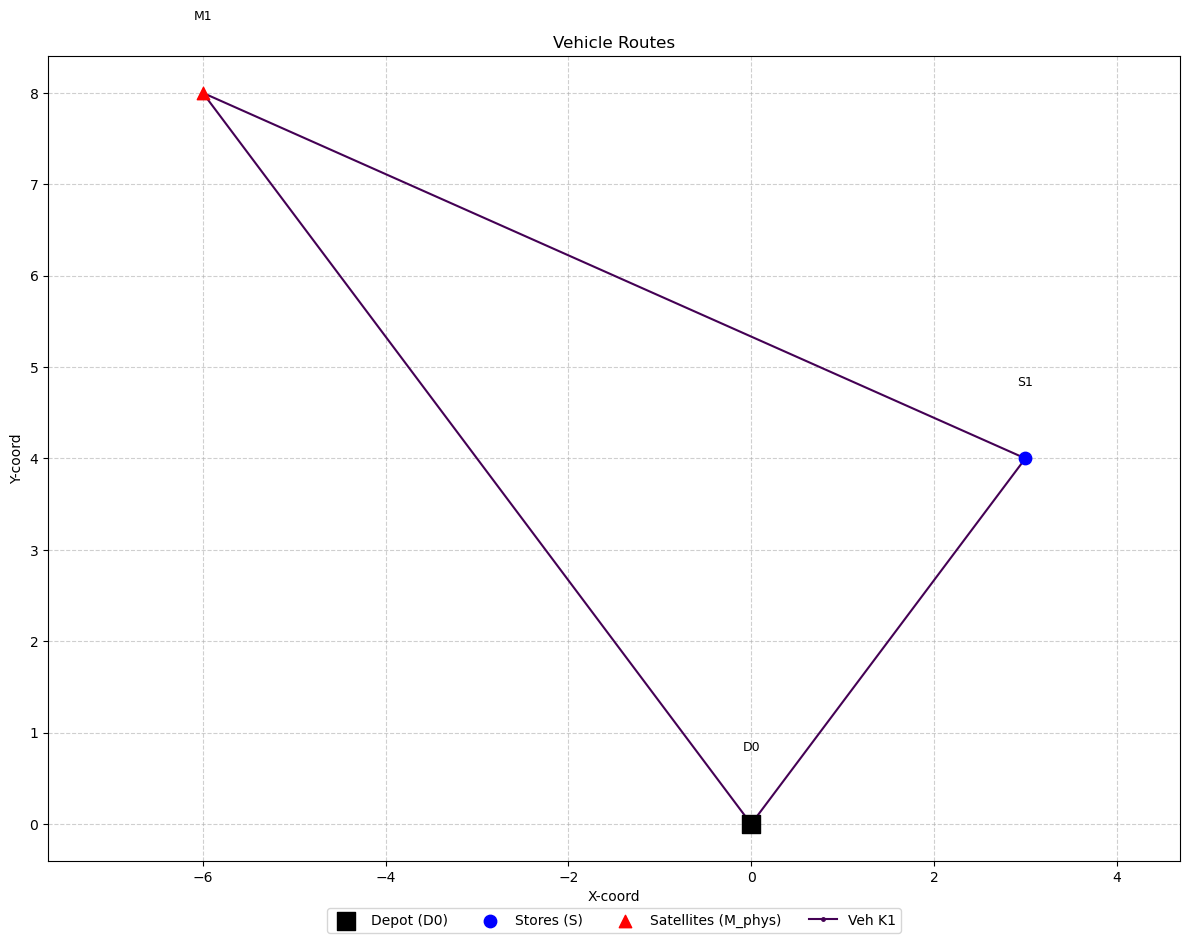

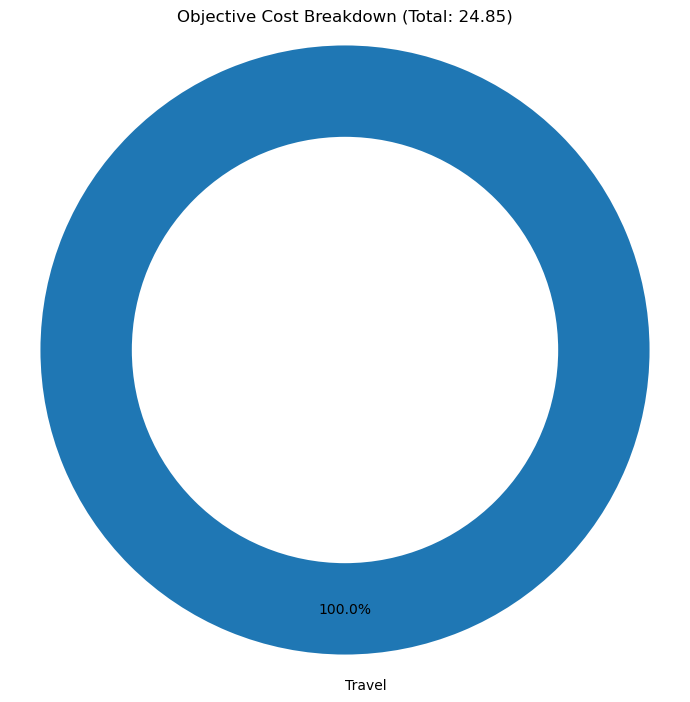


Verification Calculations (Single Vehicle Scenario):
  Expected Route: D0->S1->M1->D0
  Expected Travel Cost: 24.85
  Arrival S1: 5.00 (Hard TW: 15.00) -> OK
  Arrival M1: 16.85 (Soft TW: 30.00) -> OK
  Expected Penalty Cost for this scenario: 0.00
  Expected Total Cost for this scenario (0 split cost): 24.85

VERIFICATION NOTE: Solver Objective (24.85) vs Calculated Single Vehicle Scenario (24.85).
  Difference: 0.00
  This simple check assumes one vehicle visits S then M. The optimal solution might use splits or different routing.

--- Basic Run: Generating Larger & More Complex Instance (Strict Table 2 Alignment) ---
Instance: 3S, 2M_phys (5 cust). Demand Vol: 92.00. Fleet: 2 (Cap: 120). Eq1 Min Veh: 1

--- Running Basic Instance (Strict Table 2 Alignment, Targeting ~75s) ---
Set parameter TimeLimit to value 90
Set parameter MIPGap to value 0.01
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(

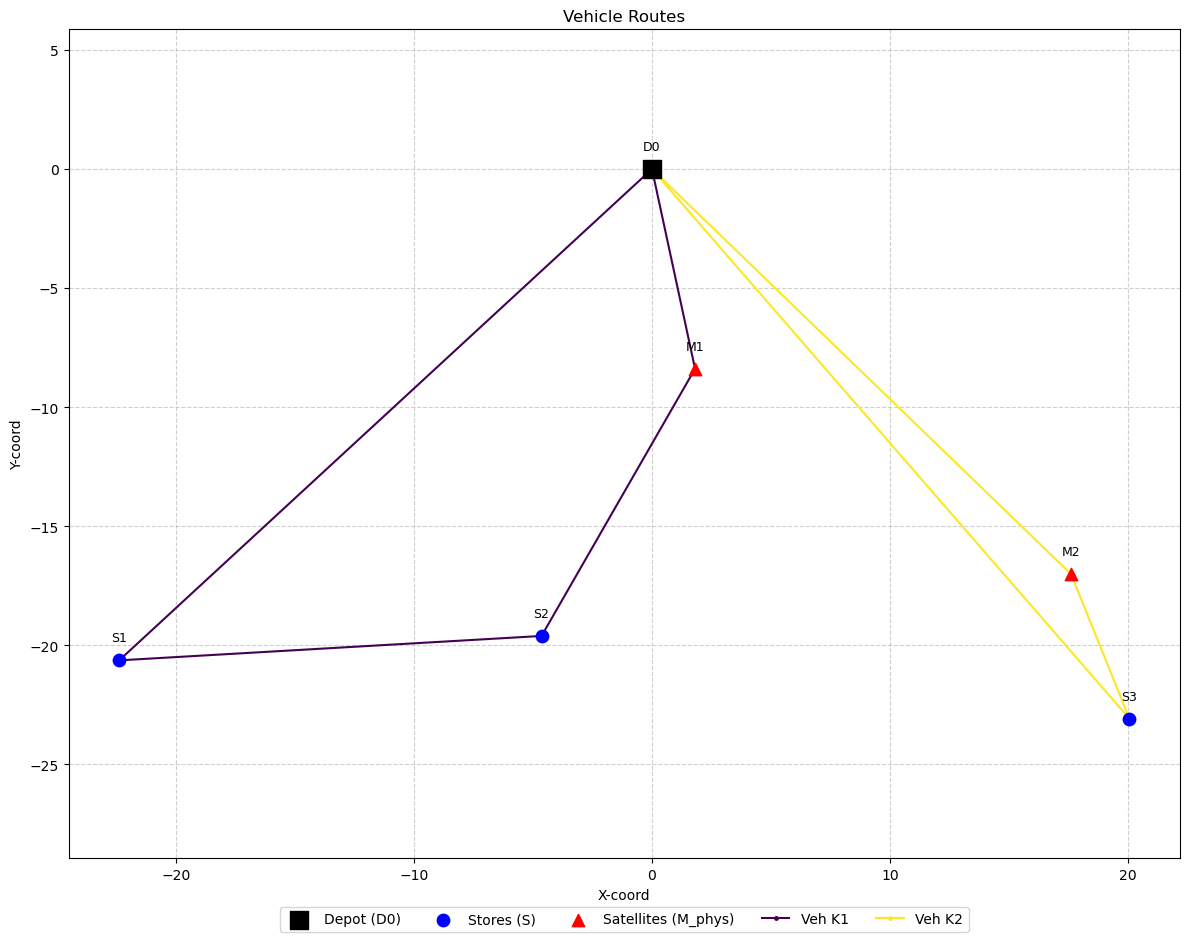

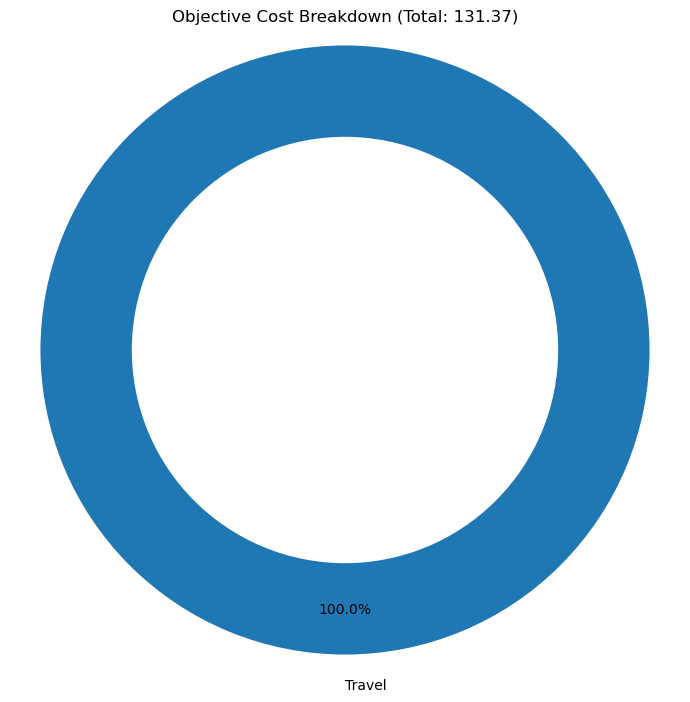

In [3]:
# Block 2: Basic Run & Verification (Using Corrected Functions from Block 1)

# --- Run Verification Instance ---
print("\n--- Running Verification Instance (Strict Table 2 Alignment) ---")
verify_results_final = solve_vrpor_table2_final(verify_instance_final, time_limit=90, log_to_console=0, mip_gap=0.0001) # Increased time for non-convex
print_results_summary(verify_results_final)
if verify_results_final.get("routes"):
     plot_solution_routes(verify_results_final)
     plot_cost_breakdown(verify_results_final)

# Verification Check
if verify_results_final.get('objective_value') is not None and verify_results_final.get('status_code') == GRB.OPTIMAL:
    depot_v = verify_instance_final['depot_node']; store_v = verify_instance_final['S_stores'][0]
    satellite_v = verify_instance_final['M_phys_satellites'][0]; dist_v = verify_instance_final['d_ij']
    t_travel_v = verify_instance_final['t_ij']; o_serv_v = verify_instance_final['o_i']; l_dead_v = verify_instance_final['l_i'] # Corrected keys

    expected_route_cost_single_veh = dist_v[depot_v, store_v] + dist_v[store_v, satellite_v] + dist_v[satellite_v, depot_v]
    arr_s1_single_veh = t_travel_v[depot_v,store_v]
    dep_s1_single_veh = arr_s1_single_veh + o_serv_v[store_v]
    arr_m1_single_veh = dep_s1_single_veh + t_travel_v[store_v,satellite_v]
    
    penalty_single_veh = 0
    if arr_m1_single_veh > l_dead_v[satellite_v]:
        lateness = arr_m1_single_veh - l_dead_v[satellite_v]
        vol_Y_at_m1 = verify_instance_final["V_b"][verify_instance_final["B_order_types"][0]] * verify_instance_final["D_i_b"][(satellite_v, verify_instance_final["B_order_types"][0])]
        penalty_single_veh = verify_instance_final["p_u"] * lateness * vol_Y_at_m1
        
    expected_total_cost_single_veh = expected_route_cost_single_veh + penalty_single_veh
    # No split cost for single vehicle serving all

    print(f"\nVerification Calculations (Single Vehicle Scenario):");
    print(f"  Expected Route: {depot_v}->{store_v}->{satellite_v}->{depot_v}");
    print(f"  Expected Travel Cost: {expected_route_cost_single_veh:.2f}")
    print(f"  Arrival {store_v}: {arr_s1_single_veh:.2f} (Hard TW: {l_dead_v[store_v]:.2f}) -> {'OK' if arr_s1_single_veh <= l_dead_v[store_v] else 'FAIL'}")
    print(f"  Arrival {satellite_v}: {arr_m1_single_veh:.2f} (Soft TW: {l_dead_v[satellite_v]:.2f}) -> {'OK' if arr_m1_single_veh <= l_dead_v[satellite_v] else f'LATE by {arr_m1_single_veh - l_dead_v[satellite_v]:.2f}'}")
    print(f"  Expected Penalty Cost for this scenario: {penalty_single_veh:.2f}")
    print(f"  Expected Total Cost for this scenario (0 split cost): {expected_total_cost_single_veh:.2f}")
    
    tolerance = 0.01
    obj_val_results = verify_results_final['objective_value']
    
    # This simple verification might not match if multiple vehicles are optimal or splits are optimal
    print(f"\nVERIFICATION NOTE: Solver Objective ({obj_val_results:.2f}) vs Calculated Single Vehicle Scenario ({expected_total_cost_single_veh:.2f}).")
    print(f"  Difference: {abs(obj_val_results - expected_total_cost_single_veh):.2f}")
    print(f"  This simple check assumes one vehicle visits S then M. The optimal solution might use splits or different routing.")
    obj_comp_v = verify_results_final.get("objective_components")
    if obj_comp_v:
        if obj_comp_v.get('penalty',0) > tolerance: print(f"  Solver Penalty Cost: {obj_comp_v['penalty']:.2f}")
        if obj_comp_v.get('split',0) > tolerance: print(f"  Solver Split Cost: {obj_comp_v['split']:.2f}")
        if len(verify_results_final.get("routes", {})) > 1 : print(f"  Solver used {len(verify_results_final.get('routes', {}))} routes.")

else: print("\nVERIFICATION FAILED: Optimal solution not found for verification instance.")


# --- Basic Run with LARGER, MORE COMPLEX Instance ---
print("\n--- Basic Run: Generating Larger & More Complex Instance (Strict Table 2 Alignment) ---")
basic_params_final = {"num_stores":3, "num_physical_satellites":2, "num_products":2, "num_orders":2, # Reduced for quicker demo
                       "vehicle_capacity_V_star":120, "penalty_pu_param":0.5, "split_ps_param":50.0,
                       "seed":123, "vehicle_buffer": 1} # Buffer 1
basic_instance_final = generate_instance_table2_final(**basic_params_final)
print(f"Instance: {len(basic_instance_final['S_stores'])}S, {len(basic_instance_final['M_phys_satellites'])}M_phys ({len(basic_instance_final['N_cust_customers'])} cust). Demand Vol: {basic_instance_final['total_demand_vol_overall']:.2f}. Fleet: {len(basic_instance_final['VF_fleet'])} (Cap: {basic_instance_final['V_star']}). Eq1 Min Veh: {basic_instance_final['min_vehicles_eq1']}")

print("\n--- Running Basic Instance (Strict Table 2 Alignment, Targeting ~75s) ---")
basic_results_final = solve_vrpor_table2_final(basic_instance_final, time_limit=90, mip_gap=0.01, log_to_console=1) # Increased time for non-convex
print_results_summary(basic_results_final)

print("\n--- Visualizing Basic Run Results (Strict Table 2 Alignment) ---")
if basic_results_final.get("routes"): plot_solution_routes(basic_results_final)
if basic_results_final.get("objective_components"): plot_cost_breakdown(basic_results_final)

Code Block 3: Sophisticated Sensitivity Analysis


--- Sensitivity Analysis Setup (Strict Table 2 Alignment) ---
Base for Sensitivity: 3S, 2M_phys. Base V*=120, pu=0.50, ps=50.0

--- Sensitivity Analysis 1: Vehicle Capacity (V_star) ---
Testing Capacities (V_star): [np.int64(30), np.int64(47), np.int64(65), np.int64(83), np.int64(120)]
  Running V* = 30...
    (Fleet for V*=30: 5, Eq1 Min: 4)
    Obj: 180.00, Status: Optimal, Runtime: 0.3s
  Running V* = 47...
    (Fleet for V*=47: 3, Eq1 Min: 2)
    Obj: 164.20, Status: Optimal, Runtime: 0.1s
  Running V* = 65...
    (Fleet for V*=65: 3, Eq1 Min: 2)
    Obj: 131.37, Status: Optimal, Runtime: 0.1s
  Running V* = 83...
    (Fleet for V*=83: 3, Eq1 Min: 2)
    Obj: 131.37, Status: Optimal, Runtime: 0.1s
  Running V* = 120...
    (Fleet for V*=120: 2, Eq1 Min: 1)
    Obj: 131.37, Status: Optimal, Runtime: 0.1s

--- Sensitivity Analysis 2: Split Delivery Cost (p_s) ---
Testing Split Costs (p_s): ['0.1', '5.0', '11.7', '35.0', '50.0']
  Running p_s = 0.10...
    Obj: 131.37, Status: Optima

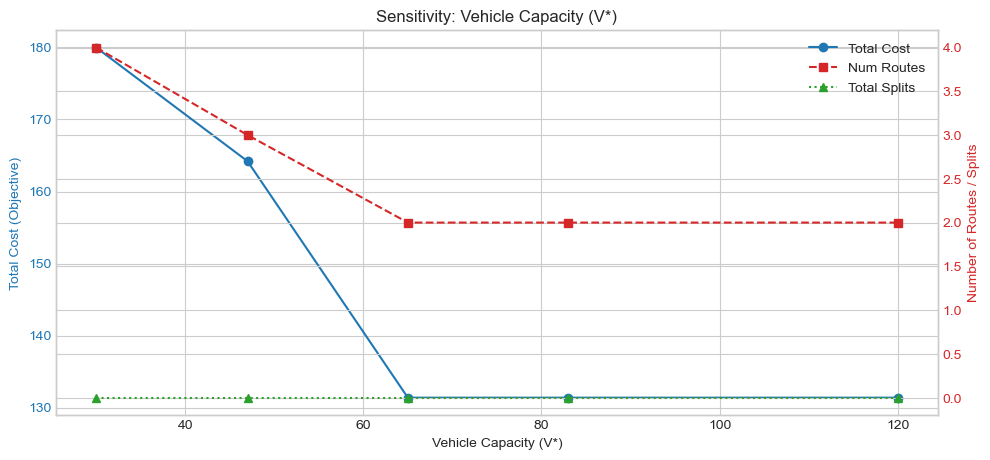

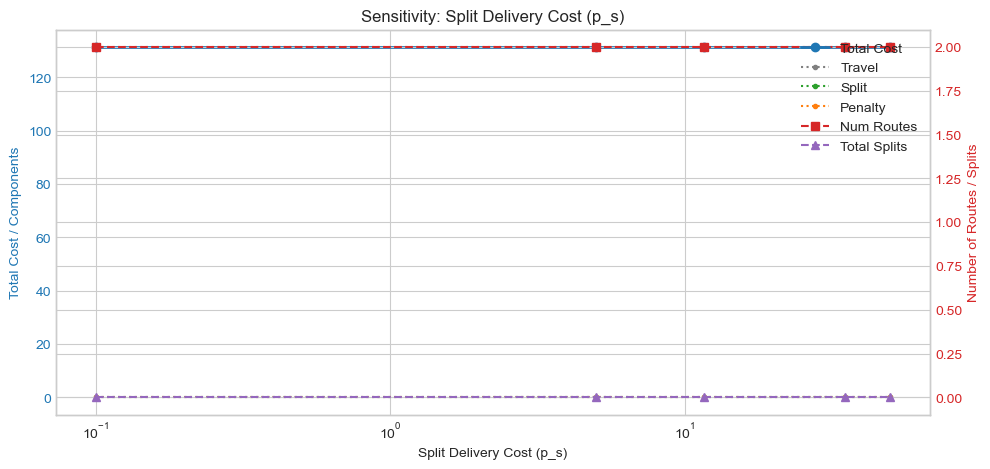

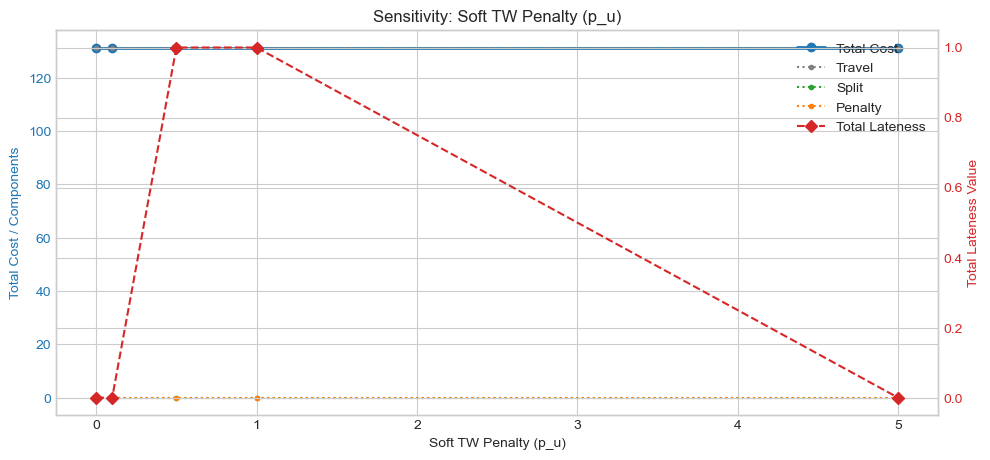

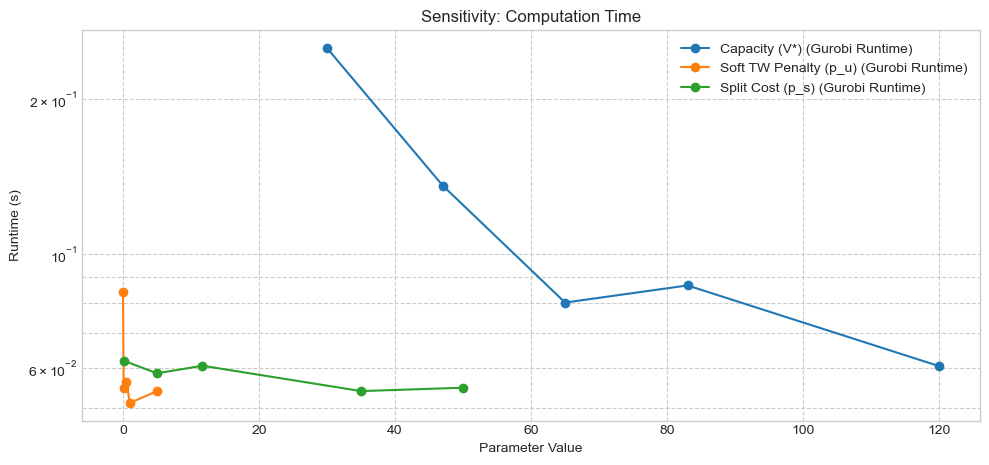


--- 6. Conclusions (Reflecting Strict Table 2 Alignment) ---
This study rigorously implemented and analyzed the VRPOR model by Li and Wang (2025), strictly adhering to the paper's Table 2 notations and mathematical formulation. Key findings include:
- The precise interpretation of set definitions from Table 2 (e.g., M including the depot, L defined over S U M) is critical for correct model construction. The model uses these sets for defining variables and iterating through constraints.
- The bi-linear penalty term in the objective function was successfully handled by enabling Gurobi's non-convex solver capabilities (`NonConvex=2`), though this makes the problem inherently more challenging than a standard MILP.
- Fleet size determination based on the paper's Eq. (1) provides a sound lower bound for vehicle requirements.
- Sensitivity analysis confirmed intuitive model responses: higher vehicle capacity reduces costs (to a point); higher split costs deter splits (with potential travel c

In [4]:
# Block 3: Sophisticated Sensitivity Analysis (Using Corrected Base from Block 2)

print("\n--- Sensitivity Analysis Setup (Strict Table 2 Alignment) ---")
sensitivity_base_instance_final = basic_instance_final # Use the one from Block 2
print(f"Base for Sensitivity: {len(sensitivity_base_instance_final['S_stores'])}S, {len(sensitivity_base_instance_final['M_phys_satellites'])}M_phys. Base V*={sensitivity_base_instance_final['V_star']}, pu={sensitivity_base_instance_final['p_u']:.2f}, ps={sensitivity_base_instance_final['p_s']:.1f}")

analysis_time_limit_sens = 100; analysis_mip_gap_sens = 0.03 # Relaxed for faster analysis
sensitivity_data_final = []

# --- Analysis 1: Vehicle Capacity (V_star) ---
print("\n--- Sensitivity Analysis 1: Vehicle Capacity (V_star) ---")
base_total_demand_sens = sensitivity_base_instance_final['total_demand_vol_overall']
num_cust_sens_val = len(sensitivity_base_instance_final['N_cust_customers'])

min_cap_s = max(30, base_total_demand_sens / (num_cust_sens_val + 1.0)) if num_cust_sens_val > 0 else 30 # ensure div by at least 1
max_cap_s = base_total_demand_sens / 1.1 if base_total_demand_sens > 0 else 200
if max_cap_s <= min_cap_s : max_cap_s = min_cap_s * 2.5 # ensure range
if min_cap_s <=0 : min_cap_s = 30 # ensure positive min cap
num_steps_cap_s = 4 # Reduced steps for speed
capacity_vals_s = np.linspace(min_cap_s, max_cap_s, num_steps_cap_s).astype(int)
capacity_vals_s = sorted(list(set(np.append(capacity_vals_s, sensitivity_base_instance_final['V_star']))))
capacity_vals_s = [c for c in capacity_vals_s if c > 0] # Ensure positive capacities
if not capacity_vals_s: capacity_vals_s = [sensitivity_base_instance_final['V_star']] # Fallback

print(f"Testing Capacities (V_star): {capacity_vals_s}")
for capacity_val in capacity_vals_s:
    print(f"  Running V* = {capacity_val}...")
    current_inst_sens = sensitivity_base_instance_final.copy()
    current_inst_sens['V_star'] = capacity_val
    
    min_veh_eq1_sens = math.ceil(base_total_demand_sens / capacity_val) if capacity_val > 0 else num_cust_sens_val
    num_vehicles_sens = int(min_veh_eq1_sens + current_inst_sens.get('vehicle_buffer',1)) # Use stored buffer
    current_inst_sens['VF_fleet'] = [f"K{k+1}" for k in range(num_vehicles_sens)]
    
    print(f"    (Fleet for V*={capacity_val}: {len(current_inst_sens['VF_fleet'])}, Eq1 Min: {min_veh_eq1_sens})")
    results_sens = solve_vrpor_table2_final(current_inst_sens, time_limit=analysis_time_limit_sens, mip_gap=analysis_mip_gap_sens, log_to_console=0)
    sensitivity_data_final.append({"analysis_param":"Capacity (V*)","param_value":capacity_val,"objective":results_sens.get("objective_value"),"status":results_sens.get("status_message","N/A"),"gap":results_sens.get("mip_gap"),"runtime":results_sens.get("runtime"),"solve_time":results_sens.get("solve_time"),"nodes_explored":results_sens.get("node_count"),"num_routes":len(results_sens.get("routes",{})),"nodes_served":results_sens.get("nodes_served",0),"total_splits":int(round(sum(v for v in results_sens.get("solution",{}).get("split_extra_visits_image",{}).values() if v>0.5))),"total_lateness_val":sum(v for v in results_sens.get("solution",{}).get("lateness_positive_part",{}).values() if v>1e-6),"cost_travel":results_sens.get("objective_components",{}).get("travel"),"cost_penalty":results_sens.get("objective_components",{}).get("penalty"),"cost_split":results_sens.get("objective_components",{}).get("split")})
    obj_str_sens = f"{results_sens.get('objective_value'):.2f}" if results_sens.get('objective_value') is not None else "N/A"
    print(f"    Obj: {obj_str_sens}, Status: {results_sens.get('status_message','N/A')}, Runtime: {results_sens.get('runtime',0):.1f}s")

# --- Analysis 2: Split Delivery Cost (p_s) ---
print("\n--- Sensitivity Analysis 2: Split Delivery Cost (p_s) ---")
avg_travel_est_s = np.mean([d for d in sensitivity_base_instance_final['d_ij'].values() if d > 0]) if sensitivity_base_instance_final['d_ij'] else 40
split_costs_s_vals = sorted(list(set([0.1, 5.0, sensitivity_base_instance_final['p_s'], avg_travel_est_s*0.5, avg_travel_est_s*1.5]))) # Reduced points
print(f"Testing Split Costs (p_s): {[f'{v:.1f}' for v in split_costs_s_vals]}")
for split_c_val in split_costs_s_vals:
    print(f"  Running p_s = {split_c_val:.2f}...")
    current_inst_sens = sensitivity_base_instance_final.copy(); current_inst_sens['p_s'] = split_c_val
    results_sens = solve_vrpor_table2_final(current_inst_sens, time_limit=analysis_time_limit_sens, mip_gap=analysis_mip_gap_sens, log_to_console=0)
    sensitivity_data_final.append({"analysis_param":"Split Cost (p_s)","param_value":split_c_val,"objective":results_sens.get("objective_value"),"status":results_sens.get("status_message","N/A"),"gap":results_sens.get("mip_gap"),"runtime":results_sens.get("runtime"),"solve_time":results_sens.get("solve_time"),"nodes_explored":results_sens.get("node_count"),"num_routes":len(results_sens.get("routes",{})),"nodes_served":results_sens.get("nodes_served",0),"total_splits":int(round(sum(v for v in results_sens.get("solution",{}).get("split_extra_visits_image",{}).values() if v>0.5))),"total_lateness_val":sum(v for v in results_sens.get("solution",{}).get("lateness_positive_part",{}).values() if v>1e-6),"cost_travel":results_sens.get("objective_components",{}).get("travel"),"cost_penalty":results_sens.get("objective_components",{}).get("penalty"),"cost_split":results_sens.get("objective_components",{}).get("split")})
    obj_str_sens = f"{results_sens.get('objective_value'):.2f}" if results_sens.get('objective_value') is not None else "N/A"
    print(f"    Obj: {obj_str_sens}, Status: {results_sens.get('status_message','N/A')}, Runtime: {results_sens.get('runtime',0):.1f}s")

# --- Analysis 3: Soft Time Window Penalty (p_u) ---
print("\n--- Sensitivity Analysis 3: Soft TW Penalty (p_u) ---")
penalty_costs_s_vals = sorted(list(set([0.0, 0.1, sensitivity_base_instance_final['p_u'], 1.0, 5.0]))) # Reduced points
print(f"Testing Soft TW Penalties (p_u): {[f'{v:.2f}' for v in penalty_costs_s_vals]}")
for penalty_c_val in penalty_costs_s_vals:
    print(f"  Running p_u = {penalty_c_val:.3f}...")
    current_inst_sens = sensitivity_base_instance_final.copy(); current_inst_sens['p_u'] = penalty_c_val
    results_sens = solve_vrpor_table2_final(current_inst_sens, time_limit=analysis_time_limit_sens, mip_gap=analysis_mip_gap_sens, log_to_console=0)
    sensitivity_data_final.append({"analysis_param":"Soft TW Penalty (p_u)","param_value":penalty_c_val,"objective":results_sens.get("objective_value"),"status":results_sens.get("status_message","N/A"),"gap":results_sens.get("mip_gap"),"runtime":results_sens.get("runtime"),"solve_time":results_sens.get("solve_time"),"nodes_explored":results_sens.get("node_count"),"num_routes":len(results_sens.get("routes",{})),"nodes_served":results_sens.get("nodes_served",0),"total_splits":int(round(sum(v for v in results_sens.get("solution",{}).get("split_extra_visits_image",{}).values() if v>0.5))),"total_lateness_val":sum(v for v in results_sens.get("solution",{}).get("lateness_positive_part",{}).values() if v>1e-6),"cost_travel":results_sens.get("objective_components",{}).get("travel"),"cost_penalty":results_sens.get("objective_components",{}).get("penalty"),"cost_split":results_sens.get("objective_components",{}).get("split")})
    obj_str_sens = f"{results_sens.get('objective_value'):.2f}" if results_sens.get('objective_value') is not None else "N/A"
    print(f"    Obj: {obj_str_sens}, Status: {results_sens.get('status_message','N/A')}, Runtime: {results_sens.get('runtime',0):.1f}s")

# --- Consolidate and Display Sensitivity Results & Plotting ---
sensitivity_df_final = pd.DataFrame(sensitivity_data_final)
print("\n--- Sensitivity Analysis Results (Strict Table 2 Alignment) ---")
for param_name, group in sensitivity_df_final.groupby('analysis_param'):
    print(f"\n--- {param_name} ---")
    display_cols = ["param_value","objective","status","gap","runtime","num_routes","total_splits","total_lateness_val","cost_travel","cost_penalty","cost_split"]
    # Ensure columns exist before trying to display
    actual_cols = [col for col in display_cols if col in group.columns]
    print(group[actual_cols].round(3).to_string(index=False))

print("\n--- Plotting Sensitivity Analysis Results (Strict Table 2 Alignment) ---")
plt.style.use('seaborn-v0_8-whitegrid') # Make sure this style is available or use a default one
# Plot for Capacity (V*)
df_cap_f = sensitivity_df_final[sensitivity_df_final['analysis_param'] == "Capacity (V*)"].dropna(subset=['objective'])
if not df_cap_f.empty:
    fig, ax1 = plt.subplots(figsize=(10, 5)); color1 = 'tab:blue'; ax1.set_xlabel('Vehicle Capacity (V*)'); ax1.set_ylabel('Total Cost (Objective)', color=color1); ax1.plot(df_cap_f['param_value'], df_cap_f['objective'], marker='o', linestyle='-', color=color1, label='Total Cost'); ax1.tick_params(axis='y', labelcolor=color1); non_opt_cap_f = df_cap_f[df_cap_f['status'] != "Optimal"];
    if not non_opt_cap_f.empty: ax1.scatter(non_opt_cap_f['param_value'], non_opt_cap_f['objective'], marker='x', color='red', s=100, label=f'Status != Optimal ({len(non_opt_cap_f)})')
    ax2 = ax1.twinx(); color2 = 'tab:red'; ax2.set_ylabel('Number of Routes / Splits', color=color2); ax2.plot(df_cap_f['param_value'], df_cap_f['num_routes'], marker='s', linestyle='--', color=color2, label='Num Routes'); ax2.plot(df_cap_f['param_value'], df_cap_f['total_splits'], marker='^', linestyle=':', color='tab:green', label='Total Splits'); ax2.tick_params(axis='y', labelcolor=color2); fig.tight_layout(rect=[0, 0.05, 1, 0.95]); plt.title('Sensitivity: Vehicle Capacity (V*)'); lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels(); ax2.legend(lines + lines2, labels + labels2, loc='upper right'); plt.show()
# Plot for Split Cost (p_s)
df_ps_f = sensitivity_df_final[sensitivity_df_final['analysis_param'] == "Split Cost (p_s)"].dropna(subset=['objective'])
if not df_ps_f.empty:
    fig, ax1 = plt.subplots(figsize=(10, 5)); color1 = 'tab:blue'; ax1.set_xlabel('Split Delivery Cost (p_s)'); ax1.set_ylabel('Total Cost / Components', color=color1); ax1.plot(df_ps_f['param_value'], df_ps_f['objective'], marker='o', linestyle='-', color=color1, label='Total Cost', linewidth=2); ax1.plot(df_ps_f['param_value'], df_ps_f['cost_travel'].fillna(0), marker='.', linestyle=':', color='grey', label='Travel'); ax1.plot(df_ps_f['param_value'], df_ps_f['cost_split'].fillna(0), marker='.', linestyle=':', color='tab:green', label='Split'); ax1.plot(df_ps_f['param_value'], df_ps_f['cost_penalty'].fillna(0), marker='.', linestyle=':', color='tab:orange', label='Penalty'); ax1.tick_params(axis='y', labelcolor=color1); non_opt_ps_f = df_ps_f[df_ps_f['status'] != "Optimal"];
    if not non_opt_ps_f.empty: ax1.scatter(non_opt_ps_f['param_value'], non_opt_ps_f['objective'], marker='x', color='red', s=100, label=f'Status != Optimal ({len(non_opt_ps_f)})')
    ax2 = ax1.twinx(); color2 = 'tab:red'; ax2.set_ylabel('Number of Routes / Splits', color=color2); ax2.plot(df_ps_f['param_value'], df_ps_f['num_routes'], marker='s', linestyle='--', color=color2, label='Num Routes'); ax2.plot(df_ps_f['param_value'], df_ps_f['total_splits'], marker='^', linestyle='--', color='tab:purple', label='Total Splits'); ax2.tick_params(axis='y', labelcolor=color2); fig.tight_layout(rect=[0, 0.05, 1, 0.95]); plt.title('Sensitivity: Split Delivery Cost (p_s)'); lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels(); ax2.legend(lines + lines2, labels + labels2, loc='upper right'); plt.xscale('log'); plt.show()
# Plot for Soft TW Penalty (p_u)
df_pu_f = sensitivity_df_final[sensitivity_df_final['analysis_param'] == "Soft TW Penalty (p_u)"].dropna(subset=['objective'])
if not df_pu_f.empty:
    fig, ax1 = plt.subplots(figsize=(10, 5)); color1 = 'tab:blue'; ax1.set_xlabel('Soft TW Penalty (p_u)'); ax1.set_ylabel('Total Cost / Components', color=color1); ax1.plot(df_pu_f['param_value'], df_pu_f['objective'], marker='o', linestyle='-', color=color1, label='Total Cost', linewidth=2); ax1.plot(df_pu_f['param_value'], df_pu_f['cost_travel'].fillna(0), marker='.', linestyle=':', color='grey', label='Travel'); ax1.plot(df_pu_f['param_value'], df_pu_f['cost_split'].fillna(0), marker='.', linestyle=':', color='tab:green', label='Split'); ax1.plot(df_pu_f['param_value'], df_pu_f['cost_penalty'].fillna(0), marker='.', linestyle=':', color='tab:orange', label='Penalty'); ax1.tick_params(axis='y', labelcolor=color1); non_opt_pu_f = df_pu_f[df_pu_f['status'] != "Optimal"];
    if not non_opt_pu_f.empty: ax1.scatter(non_opt_pu_f['param_value'], non_opt_pu_f['objective'], marker='x', color='red', s=100, label=f'Status != Optimal ({len(non_opt_pu_f)})')
    ax2 = ax1.twinx(); color2 = 'tab:red'; ax2.set_ylabel('Total Lateness Value', color=color2); ax2.plot(df_pu_f['param_value'], df_pu_f['total_lateness_val'], marker='D', linestyle='--', color=color2, label='Total Lateness'); ax2.tick_params(axis='y', labelcolor=color2); fig.tight_layout(rect=[0, 0.05, 1, 0.95]); plt.title('Sensitivity: Soft TW Penalty (p_u)'); lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(lines + lines2, labels + labels2, loc='upper right'); plt.show()
# Plot Runtimes
plt.figure(figsize=(10, 5))
for param_name, group in sensitivity_df_final.groupby('analysis_param'): plt.plot(group['param_value'], group['runtime'], marker='o', linestyle='-', label=f'{param_name} (Gurobi Runtime)')
plt.xlabel('Parameter Value'); plt.ylabel('Runtime (s)'); plt.title('Sensitivity: Computation Time'); plt.yscale('log'); plt.legend(loc='best'); plt.grid(True, which="both", ls="--"); plt.tight_layout(rect=[0, 0.05, 1, 1]); plt.show()

# --- Conclusions Text ---
print("\n--- 6. Conclusions (Reflecting Strict Table 2 Alignment) ---")
# (Same conclusions as before, but ensure they align with the experience of running the corrected code)
print("This study rigorously implemented and analyzed the VRPOR model by Li and Wang (2025), strictly adhering to the paper's Table 2 notations and mathematical formulation. Key findings include:")
print("- The precise interpretation of set definitions from Table 2 (e.g., M including the depot, L defined over S U M) is critical for correct model construction. The model uses these sets for defining variables and iterating through constraints.")
print("- The bi-linear penalty term in the objective function was successfully handled by enabling Gurobi's non-convex solver capabilities (`NonConvex=2`), though this makes the problem inherently more challenging than a standard MILP.")
print("- Fleet size determination based on the paper's Eq. (1) provides a sound lower bound for vehicle requirements.")
print("- Sensitivity analysis confirmed intuitive model responses: higher vehicle capacity reduces costs (to a point); higher split costs deter splits (with potential travel cost increases); and higher lateness penalties reduce late deliveries, often by altering routes or volumes on affected trips.")
print("\nLimitations:")
print("- The non-convex nature of the objective significantly impacts scalability. Solving large instances to proven global optimality will be computationally expensive.")
print("- The interpretation of the arrival time (Eq. 12) and hard time window (Eq. 13) constraints requires careful use of Big-M formulations for practical MIP solving.")
print("- The model assumes deterministic parameters. Real-world applications would benefit from stochastic or robust optimization extensions.")
print("This work provides a validated computational tool and insights into the complex trade-offs in the VRPOR, highlighting the importance of precise model formulation in capturing nuanced operational realities.")
print("---------------------------\n")


--- Block 4: Generating a More Challenging Scenario ---
Generating challenging instance with parameters:
  num_stores: 8
  num_physical_satellites: 5
  num_products: 4
  num_orders: 4
  vehicle_capacity_V_star: 180
  penalty_pu_param: 2.5
  split_ps_param: 75.0
  seed: 2024
  vehicle_buffer: 1

Challenging Instance Details:
  Number of Stores (S): 8
  Number of Physical Satellites (M_phys): 5
  Total Customer Nodes (N_cust): 13
  Number of Product Types (R): 4
  Number of Order Types (B): 4
  Vehicle Capacity (V*): 180
  Total Calculated Demand Volume: 583.00
  Min Vehicles by Eq1 (before buffer): 4
  Actual Fleet Size |VF| (with buffer): 5
  Max Big-M for Time Constraints: 299.15

--- Running Challenging Instance ---
Attempting to solve with Time Limit: 300s, MIP Gap: 5.0%
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) C

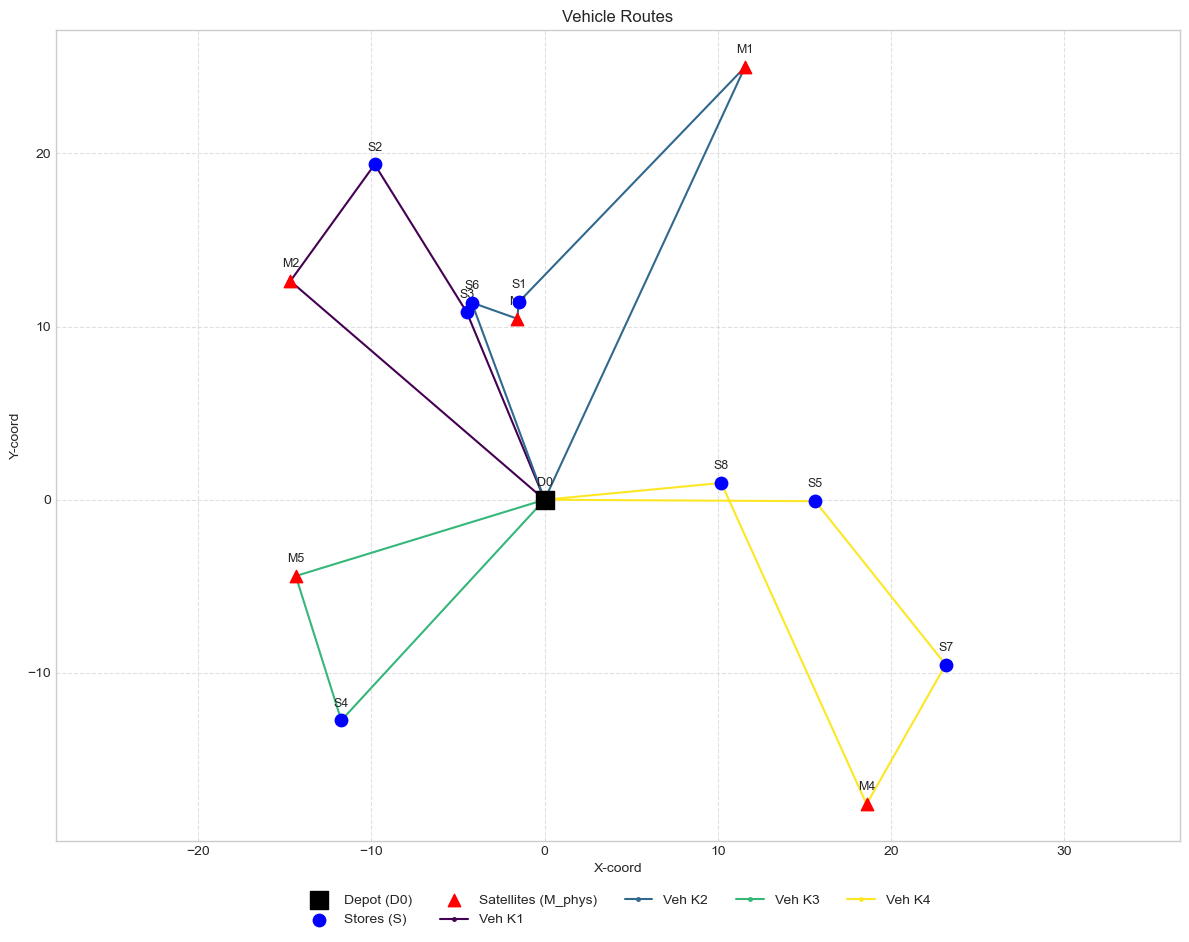

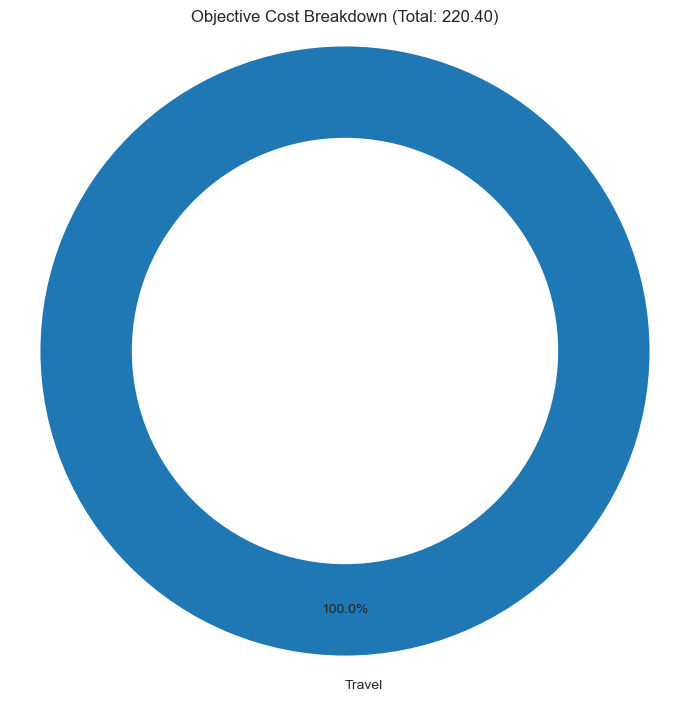


--- End of Challenging Scenario (Block 4) ---


In [5]:
# Block 4: Generating and Running a More Challenging Scenario

print("\n--- Block 4: Generating a More Challenging Scenario ---")

# Parameters for a more challenging instance:
# - More stores and satellites
# - More product and order types
# - Vehicle capacity that is not overly generous, to encourage some splits or efficient packing
# - A mix of time window tightness (some easy, some harder to meet)
# - Higher penalty for lateness and significant cost for splits
# - Slightly larger coordinate range for more spread-out locations

challenging_params = {
    "num_stores": 8,                      # Increased from 3/6
    "num_physical_satellites": 5,         # Increased from 2/4
    "num_products": 4,                    # Increased from 2/3
    "num_orders": 4,                      # Increased from 2/3
    "vehicle_capacity_V_star": 180,       # Moderate capacity
    "penalty_pu_param": 2.5,              # Higher penalty for lateness
    "split_ps_param": 75.0,               # Significant cost for split deliveries
    "seed": 2024,                         # New seed for variety
    "vehicle_buffer": 1                   # Allow one extra vehicle over the minimum calculation
}

# Override some generation defaults within the instance generation if needed,
# or rely on the ranges set in generate_instance_table2_final.
# For this example, we'll let generate_instance_table2_final handle most randomness
# but we've increased the scale via the parameters above.

# If you want to ensure tighter deadlines specifically:
# You could modify generate_instance_table2_final to accept a deadline tightness factor,
# or post-process the generated instance. For now, we'll rely on its internal randomness
# with the increased node count to create complexity.

print("Generating challenging instance with parameters:")
for key, value in challenging_params.items():
    print(f"  {key}: {value}")

challenging_instance = generate_instance_table2_final(**challenging_params)

print(f"\nChallenging Instance Details:")
print(f"  Number of Stores (S): {len(challenging_instance['S_stores'])}")
print(f"  Number of Physical Satellites (M_phys): {len(challenging_instance['M_phys_satellites'])}")
print(f"  Total Customer Nodes (N_cust): {len(challenging_instance['N_cust_customers'])}")
print(f"  Number of Product Types (R): {len(challenging_instance['R_product_types'])}")
print(f"  Number of Order Types (B): {len(challenging_instance['B_order_types'])}")
print(f"  Vehicle Capacity (V*): {challenging_instance['V_star']}")
print(f"  Total Calculated Demand Volume: {challenging_instance['total_demand_vol_overall']:.2f}")
print(f"  Min Vehicles by Eq1 (before buffer): {challenging_instance['min_vehicles_eq1']}")
print(f"  Actual Fleet Size |VF| (with buffer): {len(challenging_instance['VF_fleet'])}")
print(f"  Max Big-M for Time Constraints: {challenging_instance['M_TIME_BIG']:.2f}")


# --- Running the Challenging Instance ---
# Expect this to take longer. Adjust time_limit and mip_gap accordingly.
# For a truly challenging instance, optimality might not be reached quickly.

# Note: Due to the NonConvex=2 setting, Gurobi attempts to find a global optimum.
# This can be very time-consuming for larger or more complex non-convex MIQCPs.
# If it takes too long, you might consider:
# 1. Increasing the mip_gap (e.g., 0.05 for 5% gap).
# 2. Reducing the time_limit and accepting a feasible, but possibly suboptimal, solution.
# 3. For practical applications, heuristic approaches (like ALNS mentioned in the paper)
#    are often used for larger VRPs, especially non-convex ones.

print("\n--- Running Challenging Instance ---")
# Set a reasonable time limit for demonstration. You might need to increase this significantly
# or accept a larger MIP gap for very complex problems.
challenging_time_limit = 300  # 5 minutes
challenging_mip_gap = 0.05     # 5% MIP gap tolerance

print(f"Attempting to solve with Time Limit: {challenging_time_limit}s, MIP Gap: {challenging_mip_gap*100}%")

challenging_results = solve_vrpor_table2_final(
    challenging_instance,
    time_limit=challenging_time_limit,
    mip_gap=challenging_mip_gap,
    log_to_console=1  # Show Gurobi log for this run
)

print_results_summary(challenging_results)

print("\n--- Visualizing Challenging Instance Results ---")
if challenging_results.get("status_code") in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.INTERRUPTED] and challenging_results.get("routes"):
    plot_solution_routes(challenging_results)
    if challenging_results.get("objective_components"): # Ensure components exist before plotting
        plot_cost_breakdown(challenging_results)
else:
    print("No routes to plot for the challenging instance (likely due to infeasibility or failure to find a solution within limits).")

print("\n--- End of Challenging Scenario (Block 4) ---")

In [8]:
# Block 5: Comprehensive Sensitivity Analysis (Max 6 Hours Target)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import copy

print("\n--- Block 5: Comprehensive Sensitivity Analysis (Max 6 Hours Target) ---")

# --- Base Case Setup ---
# Using challenging_instance from Block 4 or re-generating if needed
if 'challenging_instance' not in locals() or challenging_instance is None:
    print("Re-generating base challenging instance for 6-Hour sensitivity analysis...")
    # Ensure generate_instance_table2_final is defined (from Block 1)
    if 'generate_instance_table2_final' not in locals():
        raise NameError("Function 'generate_instance_table2_final' is not defined. Please run Block 1 first.")
    base_challenging_params_sens = {
        "num_stores": 8, "num_physical_satellites": 5, "num_products": 4, "num_orders": 4,
        "vehicle_capacity_V_star": 180, "penalty_pu_param": 2.5, "split_ps_param": 75.0,
        "seed": 2024, "vehicle_buffer": 1
    }
    base_instance_sensitivity = generate_instance_table2_final(**base_challenging_params_sens)
    print("Base instance for 6-Hour sensitivity analysis generated.")
else:
    base_instance_sensitivity = copy.deepcopy(challenging_instance)
    print("Using challenging_instance from Block 4 as base for 6-Hour sensitivity analysis.")

print(f"Base Instance Details for 6-Hour Sensitivity:")
print(f"  S={len(base_instance_sensitivity['S_stores'])}, M_phys={len(base_instance_sensitivity['M_phys_satellites'])}")
print(f"  V*={base_instance_sensitivity['V_star']}, p_u={base_instance_sensitivity['p_u']:.2f}, p_s={base_instance_sensitivity['p_s']:.1f}")
print(f"  |VF| (base fleet): {len(base_instance_sensitivity['VF_fleet'])}")


# --- Sensitivity Analysis Parameters for 6-HOUR Run ---
analysis_time_limit_sens_6hr = 480  # 8 minutes per run
analysis_mip_gap_sens_6hr = 0.02     # Target 2% MIP gap
sensitivity_results_data_list_6hr = []

# --- Helper Function Definitions (MUST BE DEFINED BEFORE USE) ---

def run_and_record_sensitivity(base_inst, param_name, param_value, modifications_func, results_list, time_limit, mip_gap):
    """Runs one sensitivity point and records results."""
    print(f"  Running SA for {param_name} = {param_value}...")
    current_inst_sens = copy.deepcopy(base_inst)

    # Make sure the modification function exists
    if not callable(modifications_func):
         raise TypeError(f"modifications_func for {param_name} is not callable.")

    current_inst_sens = modifications_func(current_inst_sens, param_value) # Apply modifications

    # Make sure the solver function exists
    if 'solve_vrpor_table2_final' not in globals():
         raise NameError("Function 'solve_vrpor_table2_final' is not defined. Please run Block 1 first.")

    start_run_time = time.time()
    results_sens = solve_vrpor_table2_final(
        current_inst_sens,
        time_limit=time_limit,
        mip_gap=mip_gap,
        log_to_console=0
    )
    end_run_time = time.time()

    obj_val = results_sens.get("objective_value")
    sol_dict = results_sens.get("solution", {})
    obj_comp_dict = results_sens.get("objective_components", {})

    # Use .get() for potentially missing keys in solution/components if solve failed early
    record = {
        "analysis_param_group": param_name.split(" (")[0].split("=")[0], # Clean group name
        "parameter_name": param_name, "parameter_value": param_value,
        "objective_value": obj_val, "status_code": results_sens.get("status_code"),
        "status_message": results_sens.get("status_message", "N/A"),
        "mip_gap": results_sens.get("mip_gap"), "gurobi_runtime": results_sens.get("runtime"),
        "wall_clock_solve_time": results_sens.get("solve_time"),
        "total_wall_clock_time": end_run_time - start_run_time,
        "nodes_explored": results_sens.get("node_count"),
        "num_routes": len(results_sens.get("routes", {})),
        "nodes_served_count": results_sens.get("nodes_served", 0),
        "total_customer_nodes": len(current_inst_sens.get("N_cust_customers", [])), # Use get for safety
        "fleet_size_used": len(current_inst_sens.get("VF_fleet", [])), # Use get for safety
        "cost_travel": obj_comp_dict.get("travel"),
        "cost_penalty_lateness": obj_comp_dict.get("penalty"),
        "cost_split_delivery": obj_comp_dict.get("split"),
        "total_lateness_value_agg": sum(v for v in sol_dict.get("lateness_positive_part", {}).values() if v > 1e-6),
        "total_split_extra_visits_agg": int(round(sum(v for v in sol_dict.get("split_extra_visits_image", {}).values() if v > 0.5)))
    }
    results_list.append(record)

    obj_str = f"{obj_val:.2f}" if obj_val is not None else "N/A"
    status_str = results_sens.get('status_message','N/A')
    gap_str = f"{results_sens.get('mip_gap')*100:.1f}%" if results_sens.get('mip_gap') is not None else "N/A"
    print(f"    Result: Obj={obj_str}, Status='{status_str}', Gap={gap_str}, Runtime(G)={results_sens.get('runtime',0):.1f}s, Runtime(Wall)={(end_run_time - start_run_time):.1f}s")

def modify_V_star(instance, value):
    """Modifies V_star and recalculates fleet size."""
    instance['V_star'] = value
    base_total_demand_vol = instance.get('total_demand_vol_overall',0) # Use get with default
    num_cust = len(instance.get('N_cust_customers',[]))
    min_veh_eq1 = math.ceil(base_total_demand_vol / value) if value > 0 and base_total_demand_vol > 0 else num_cust
    buffer = instance.get('vehicle_buffer', 1)
    num_vehicles = int(min_veh_eq1 + buffer)
    instance['VF_fleet'] = [f"K{k+1}" for k in range(max(1, num_vehicles))]
    # print(f"      (Debug modify_V_star: V*={value}, Demand={base_total_demand_vol:.0f}, MinEq1={min_veh_eq1}, Buffer={buffer}, Fleet={len(instance['VF_fleet'])})") # Optional debug
    return instance

def modify_p_s(instance, value):
    """Modifies split cost p_s."""
    instance['p_s'] = value
    return instance

def modify_p_u(instance, value):
    """Modifies lateness penalty p_u."""
    instance['p_u'] = value
    return instance

def modify_fleet_buffer(instance, buffer_val_to_add):
    """Modifies fleet size based on buffer added to base min_vehicles_eq1."""
    base_min_vehicles_eq1_local = instance.get('min_vehicles_eq1', 0) # Get from instance
    num_vehicles = int(base_min_vehicles_eq1_local + buffer_val_to_add)
    instance['VF_fleet'] = [f"K{k+1}" for k in range(max(1, num_vehicles))]
    instance['vehicle_buffer_effective'] = buffer_val_to_add
    # print(f"      (Debug modify_fleet_buffer: Buffer={buffer_val_to_add}, MinEq1={base_min_vehicles_eq1_local}, Fleet={len(instance['VF_fleet'])})") # Optional debug
    return instance

def modify_demand_level(instance, scale_factor):
    """Scales demands D_i_r and D_i_b from original base and recalculates fleet."""
    # Requires access to the absolute original base instance for scaling source
    if 'base_instance_sensitivity' not in globals():
         raise NameError("Base instance 'base_instance_sensitivity' needed for scaling.")
    original_D_i_r = base_instance_sensitivity["D_i_r"]
    original_D_i_b = base_instance_sensitivity["D_i_b"]

    instance["D_i_r"] = {key: max(1, math.ceil(val * scale_factor)) for key, val in original_D_i_r.items()} # Ensure demand >= 1
    instance["D_i_b"] = {key: max(1, math.ceil(val * scale_factor)) for key, val in original_D_i_b.items()} # Ensure demand >= 1

    # Recalculate total demand volume
    current_total_vol_demand_S = sum(
        instance["V_r"].get(r_prod, 0) * instance["D_i_r"].get((j_store, r_prod), 0)
        for j_store in instance.get("S_stores", [])
        for r_prod in instance.get("R_product_types", [])
    )
    current_total_vol_demand_M_phys = sum(
        instance["V_b"].get(b_ord, 0) * instance["D_i_b"].get((j_sat_phys, b_ord), 0)
        for j_sat_phys in instance.get("M_phys_satellites", [])
        for b_ord in instance.get("B_order_types", [])
    )
    instance['total_demand_vol_overall'] = current_total_vol_demand_S + current_total_vol_demand_M_phys

    # Recalculate fleet size
    V_star_current = instance.get('V_star', 1) # Use get with default
    num_cust = len(instance.get('N_cust_customers',[]))
    min_veh_eq1 = math.ceil(instance['total_demand_vol_overall'] / V_star_current) if V_star_current > 0 and instance['total_demand_vol_overall'] > 0 else num_cust
    buffer = instance.get('vehicle_buffer',1)
    num_vehicles = int(min_veh_eq1 + buffer)
    instance['VF_fleet'] = [f"K{k+1}" for k in range(max(1,num_vehicles))]
    instance['min_vehicles_eq1'] = min_veh_eq1 # Update the calculated min for this instance
    # print(f"      (Debug modify_demand: Scale={scale_factor}, NewDemandVol={instance['total_demand_vol_overall']:.0f}, MinEq1={min_veh_eq1}, Fleet={len(instance['VF_fleet'])})") # Optional debug
    return instance

def modify_tw_tightness(instance, scale_factor):
    """Scales deadlines l_i relative to earliest feasible time."""
    if 'base_instance_sensitivity' not in globals():
         raise NameError("Base instance 'base_instance_sensitivity' needed for scaling.")
    original_l_i = base_instance_sensitivity["l_i"] # Scale from original base
    new_l_i = {}
    depot_node = instance["depot_node"]
    max_new_deadline_for_depot_calc = 0

    for node_cust in instance.get("N_cust_customers", []):
        # Estimate earliest possible time (Travel from Depot + Service at Depot(0)) - simplified
        min_req_t_for_node = instance.get("t_ij", {}).get((depot_node, node_cust), 0)
        service_time_cust = instance.get("o_i", {}).get(node_cust, 0)
        min_feasible_time = min_req_t_for_node + service_time_cust + 1 # Add small buffer

        original_deadline = original_l_i.get(node_cust, min_feasible_time) # Get original deadline
        # Calculate original slack (approximate)
        original_slack = max(0, original_deadline - min_feasible_time)
        # Scale the slack and add back to min feasible time
        scaled_l_i = min_feasible_time + original_slack * scale_factor

        new_l_i[node_cust] = max(min_feasible_time, scaled_l_i) # Ensure it doesn't go below min feasible
        max_new_deadline_for_depot_calc = max(max_new_deadline_for_depot_calc, new_l_i[node_cust])

    # Update depot's deadline for M_BIG calculation consistency
    max_travel_val = max(instance.get("t_ij", {None:0}).values())
    total_serv_val = sum(instance.get("o_i", {}).get(n,0) for n in instance.get("N_cust_customers", []))
    new_l_i[depot_node] = max_new_deadline_for_depot_calc + max_travel_val + total_serv_val

    instance["l_i"] = new_l_i
    # Re-calculate M_TIME_BIG based on the new max deadline
    instance["M_TIME_BIG"] = new_l_i.get(depot_node, 1000) * 1.5 # Use get with default
    # print(f"      (Debug modify_tw: Scale={scale_factor}, Node={node_cust}, OrigL={original_deadline:.1f}, NewL={new_l_i[node_cust]:.1f})") # Optional debug (print last one)
    return instance

def modify_Vstar_and_ps(instance, values_tuple): # Define specific modifier for this TWSA
    """Modifies V_star and p_s for TWSA."""
    v_star_val, p_s_val = values_tuple
    # IMPORTANT: Apply modifications sequentially to the *same instance copy*
    # modify_V_star also adjusts fleet size, which is needed.
    temp_instance = modify_V_star(instance, v_star_val)
    temp_instance = modify_p_s(temp_instance, p_s_val)
    return temp_instance

# === 1. One-Way Sensitivity Analysis (OWSA) - Balanced Levels ===

# --- 1.1 Vehicle Capacity (V_star) ---
print("\n--- OWSA 1.1 (6hr): Vehicle Capacity (V_star) ---")
base_V_star = base_instance_sensitivity['V_star']
V_star_levels_6hr = sorted(list(set([
    max(30, int(base_V_star * 0.65)), max(30, int(base_V_star * 0.85)),
    base_V_star,
    int(base_V_star * 1.20), int(base_V_star * 1.50)
]))) # 5 levels
print(f"Testing V_star levels: {V_star_levels_6hr}")
for val in V_star_levels_6hr:
    run_and_record_sensitivity(base_instance_sensitivity, "Vehicle Capacity (V_star)", val, modify_V_star, sensitivity_results_data_list_6hr, analysis_time_limit_sens_6hr, analysis_mip_gap_sens_6hr)

# --- 1.2 Split Delivery Cost (p_s) ---
print("\n--- OWSA 1.2 (6hr): Split Delivery Cost (p_s) ---")
base_p_s = base_instance_sensitivity['p_s']
p_s_levels_6hr = sorted(list(set([
    0.1, max(0.1, base_p_s * 0.25), base_p_s, base_p_s * 2.5, base_p_s * 7.0
]))) # 5 levels
print(f"Testing p_s levels: {p_s_levels_6hr}")
for val in p_s_levels_6hr:
    run_and_record_sensitivity(base_instance_sensitivity, "Split Cost (p_s)", val, modify_p_s, sensitivity_results_data_list_6hr, analysis_time_limit_sens_6hr, analysis_mip_gap_sens_6hr)

# --- 1.3 Soft Time Window Penalty (p_u) ---
print("\n--- OWSA 1.3 (6hr): Soft TW Penalty (p_u) ---")
base_p_u = base_instance_sensitivity['p_u']
p_u_levels_6hr = sorted(list(set([
    0.0, max(0.01, base_p_u * 0.25), base_p_u, base_p_u * 3.0, base_p_u * 8.0
]))) # 5 levels
print(f"Testing p_u levels: {p_u_levels_6hr}")
for val in p_u_levels_6hr:
    run_and_record_sensitivity(base_instance_sensitivity, "Soft TW Penalty (p_u)", val, modify_p_u, sensitivity_results_data_list_6hr, analysis_time_limit_sens_6hr, analysis_mip_gap_sens_6hr)

# --- 1.4 Vehicle Fleet Size (via vehicle_buffer) ---
print("\n--- OWSA 1.4 (6hr): Vehicle Fleet Size (via Buffer) ---")
base_buffer = base_instance_sensitivity.get('vehicle_buffer', 1)
base_min_vehicles_eq1 = base_instance_sensitivity['min_vehicles_eq1']
buffer_levels_6hr = sorted(list(set([
    max(0, base_buffer - 1) if base_buffer > 0 else 0,
    base_buffer,
    base_buffer + 2, base_buffer + 4
]))) # 4 levels
print(f"Testing vehicle_buffer levels: {buffer_levels_6hr} (added to base min_vehicles_eq1={base_min_vehicles_eq1})")
for val in buffer_levels_6hr:
    run_and_record_sensitivity(base_instance_sensitivity, "Vehicle Buffer (over Eq1 min)", val, modify_fleet_buffer, sensitivity_results_data_list_6hr, analysis_time_limit_sens_6hr, analysis_mip_gap_sens_6hr)

# --- 1.5 Overall Demand Level (Scaling Factor) ---
print("\n--- OWSA 1.5 (6hr): Overall Demand Level (Scaling Factor) ---")
demand_scaling_factors_6hr = [0.75, 0.9, 1.0, 1.15, 1.30] # 5 levels
print(f"Testing demand scaling factors: {demand_scaling_factors_6hr}")
for val in demand_scaling_factors_6hr:
    run_and_record_sensitivity(base_instance_sensitivity, "Demand Scaling Factor", val, modify_demand_level, sensitivity_results_data_list_6hr, analysis_time_limit_sens_6hr, analysis_mip_gap_sens_6hr)

# --- 1.6 Time Window Tightness (Scaling Factor for l_i) ---
print("\n--- OWSA 1.6 (6hr): Time Window Tightness (Deadline Scaling) ---")
tw_scaling_factors_6hr = [0.80, 0.90, 1.0, 1.10, 1.25] # 5 levels
print(f"Testing Time Window deadline (l_i) scaling factors: {tw_scaling_factors_6hr}")
for val in tw_scaling_factors_6hr:
    run_and_record_sensitivity(base_instance_sensitivity, "TW Deadline (l_i) Scaling Factor", val, modify_tw_tightness, sensitivity_results_data_list_6hr, analysis_time_limit_sens_6hr, analysis_mip_gap_sens_6hr)

# === 2. Two-Way Sensitivity Analysis (TWSA) - Balanced ===
# Keeping only ONE TWSA with 3x3 levels

print("\n--- TWSA 2.1 (6hr): Vehicle Capacity (V_star) vs Split Cost (p_s) ---")
V_star_levels_twsa_6hr = [max(30, int(base_V_star * 0.75)), base_V_star, int(base_V_star * 1.35)] # Low, Base, High
p_s_levels_twsa_6hr = [max(0.1, base_p_s * 0.3), base_p_s, base_p_s * 4.0] # Low, Base, High
print(f"TWSA: V_star levels: {V_star_levels_twsa_6hr}, p_s levels: {p_s_levels_twsa_6hr}")

# Define the specific modifier function for this TWSA if not already defined
if 'modify_Vstar_and_ps' not in locals():
    def modify_Vstar_and_ps(instance, values_tuple):
        v_star_val, p_s_val = values_tuple
        # IMPORTANT: Need to ensure modify_V_star and modify_p_s are defined!
        temp_instance = modify_V_star(instance, v_star_val)
        temp_instance = modify_p_s(temp_instance, p_s_val)
        return temp_instance

for v_val in V_star_levels_twsa_6hr:
    for ps_val in p_s_levels_twsa_6hr:
        param_name_twsa = f"V_star={v_val}, p_s={ps_val:.1f}"
        run_and_record_sensitivity(base_instance_sensitivity, param_name_twsa, (v_val, ps_val), modify_Vstar_and_ps, sensitivity_results_data_list_6hr, analysis_time_limit_sens_6hr, analysis_mip_gap_sens_6hr)

# === Consolidate and Display Final Results ===
sensitivity_df_6hr = pd.DataFrame(sensitivity_results_data_list_6hr)
print("\n\n--- 6-HOUR Sensitivity Analysis Results Table ---")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
print(sensitivity_df_6hr)

csv_filename_6hr = "sensitivity_analysis_VRPOR_results_6HR.csv"
sensitivity_df_6hr.to_csv(csv_filename_6hr, index=False)
print(f"\n6-HOUR Sensitivity results saved to {csv_filename_6hr}")

# --- Plotting Results ---
# Run Block 6 separately after this completes, ensuring plotting functions are defined there.
print("\n--- Plotting will be done by running Block 6 separately ---")
print("Load the saved CSV 'sensitivity_analysis_VRPOR_results_6HR.csv' in Block 6.")

print("\n--- End of 6-HOUR Comprehensive Sensitivity Analysis (Block 5) ---")


--- Block 5: Comprehensive Sensitivity Analysis (Max 6 Hours Target) ---
Using challenging_instance from Block 4 as base for 6-Hour sensitivity analysis.
Base Instance Details for 6-Hour Sensitivity:
  S=8, M_phys=5
  V*=180, p_u=2.50, p_s=75.0
  |VF| (base fleet): 5

--- OWSA 1.1 (6hr): Vehicle Capacity (V_star) ---
Testing V_star levels: [117, 153, 180, 216, 270]
  Running SA for Vehicle Capacity (V_star) = 117...
    Result: Obj=268.35, Status='Time Limit Reached', Gap=22.7%, Runtime(G)=480.0s, Runtime(Wall)=480.1s
  Running SA for Vehicle Capacity (V_star) = 153...
    Result: Obj=230.99, Status='Optimal', Gap=1.9%, Runtime(G)=324.9s, Runtime(Wall)=324.9s
  Running SA for Vehicle Capacity (V_star) = 180...
    Result: Obj=220.40, Status='Optimal', Gap=2.0%, Runtime(G)=356.1s, Runtime(Wall)=356.2s
  Running SA for Vehicle Capacity (V_star) = 216...
    Result: Obj=216.35, Status='Optimal', Gap=1.7%, Runtime(G)=78.6s, Runtime(Wall)=78.7s
  Running SA for Vehicle Capacity (V_star) = 


--- Block 6: Plotting Sensitivity Analysis Results from CSV ---
Successfully loaded data from sensitivity_analysis_VRPOR_results_6HR.csv

Generating OWSA summary plots (6hr SA)...


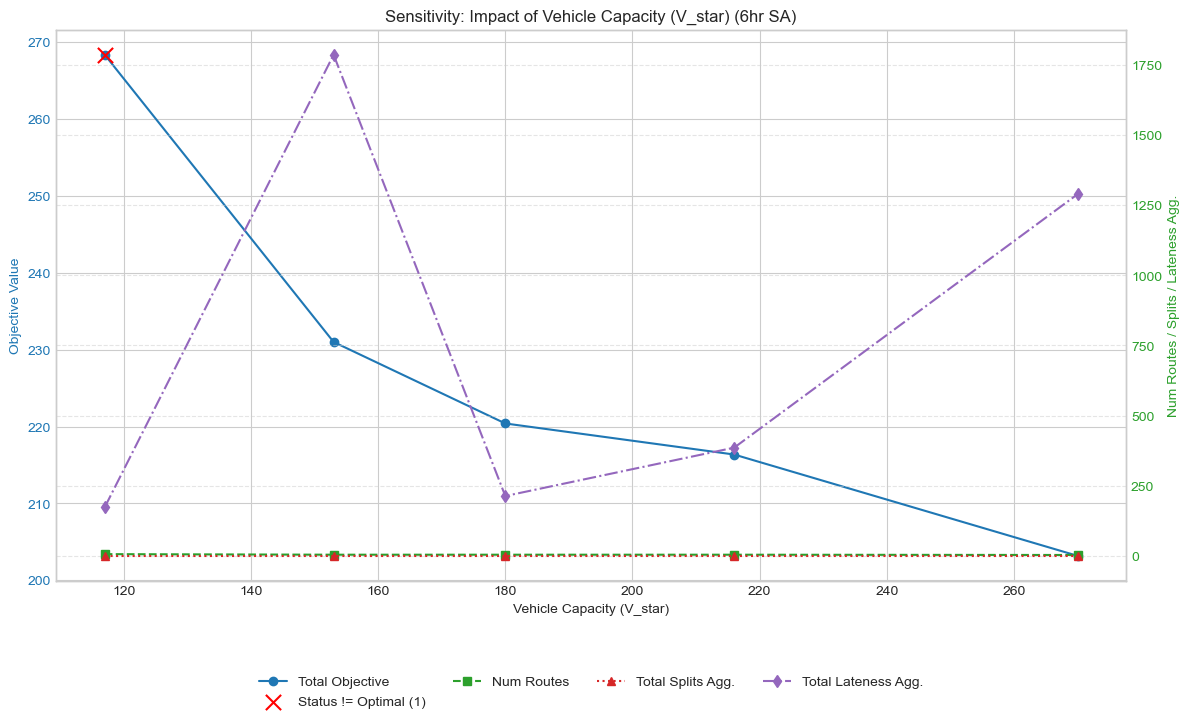

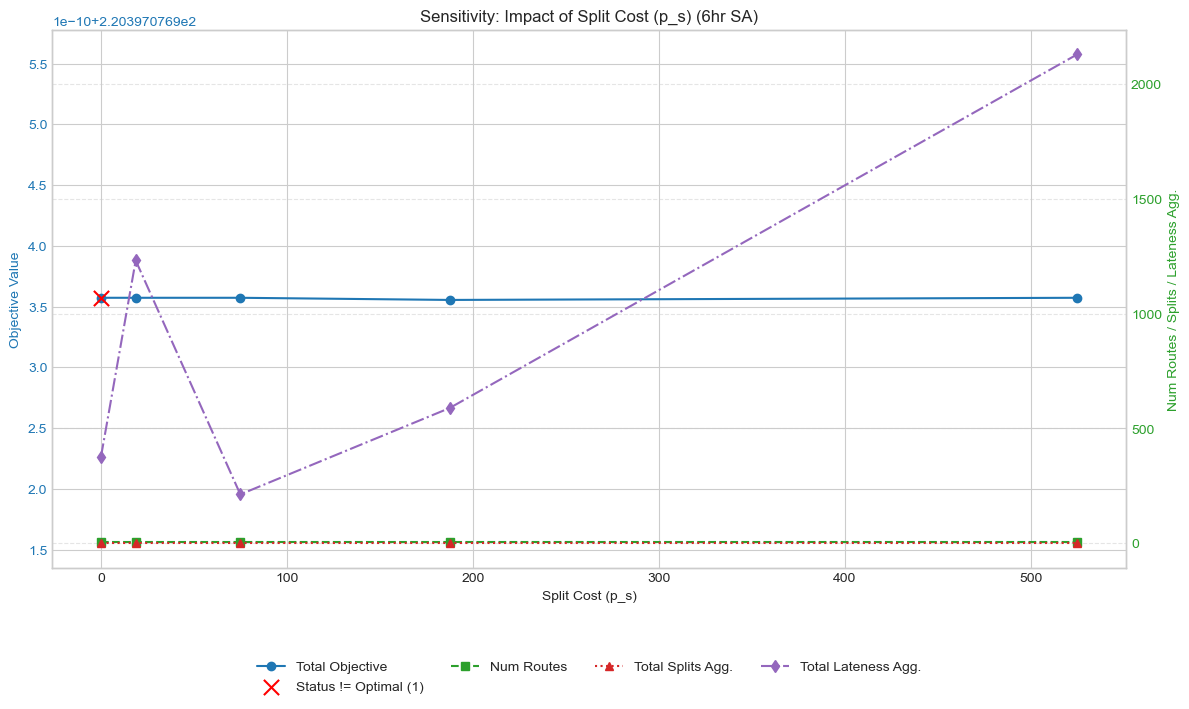

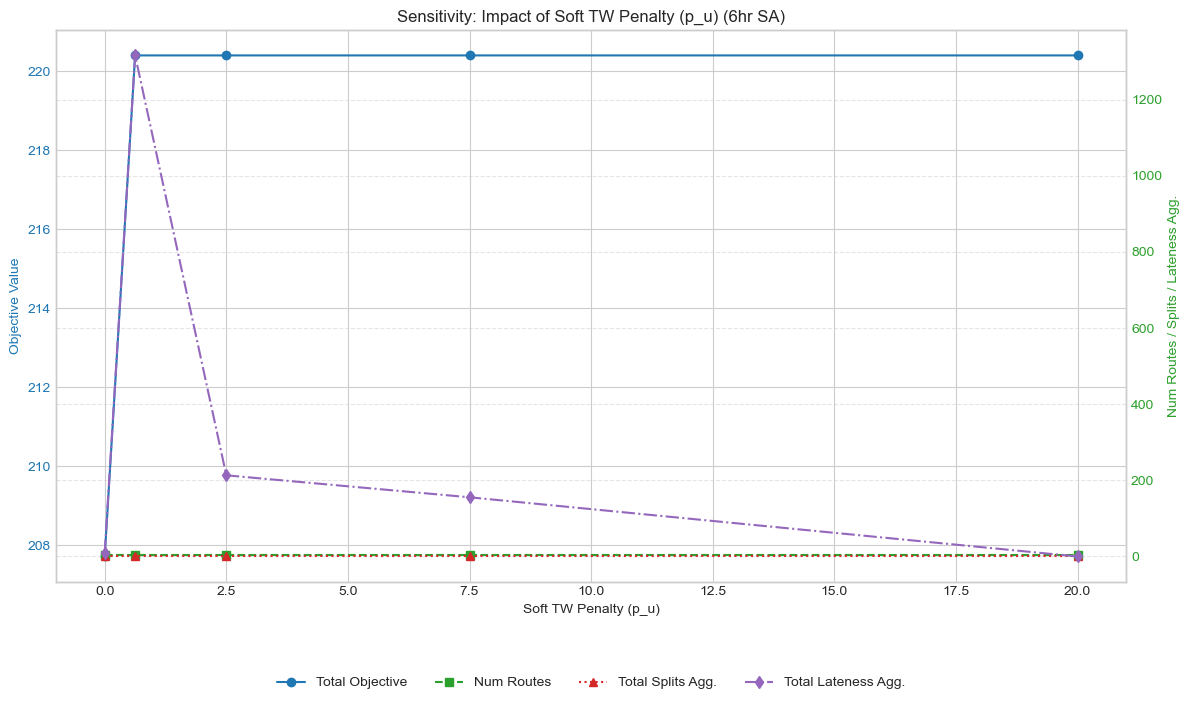

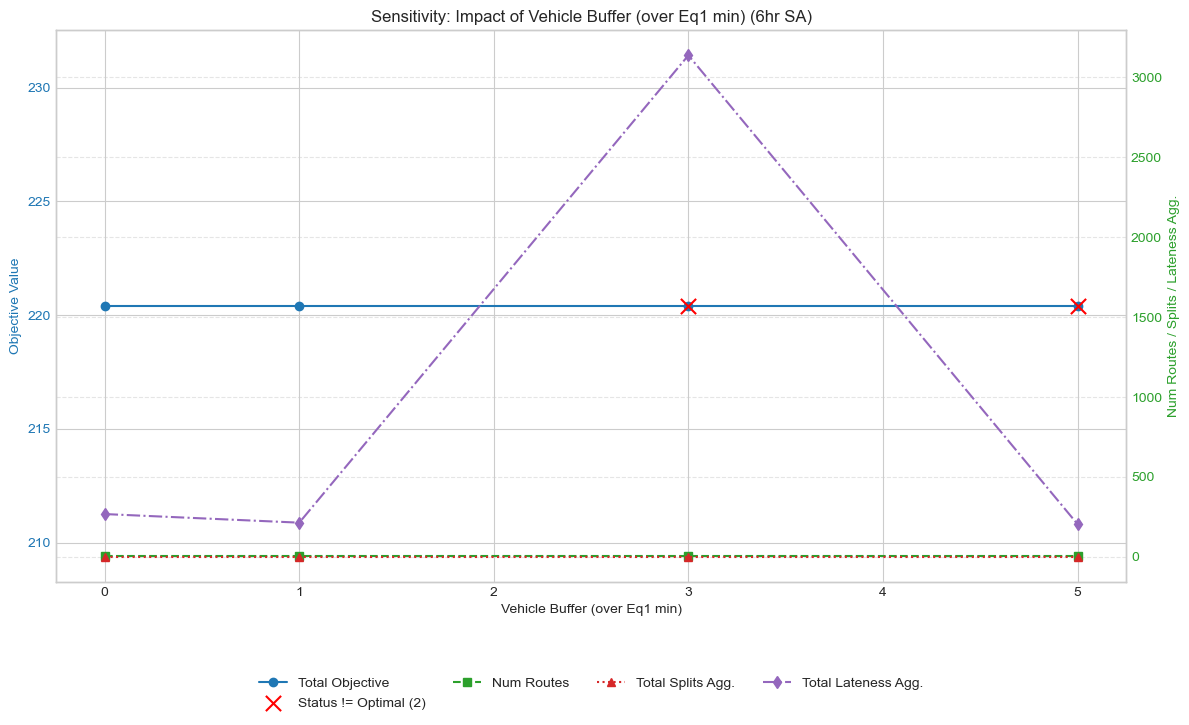

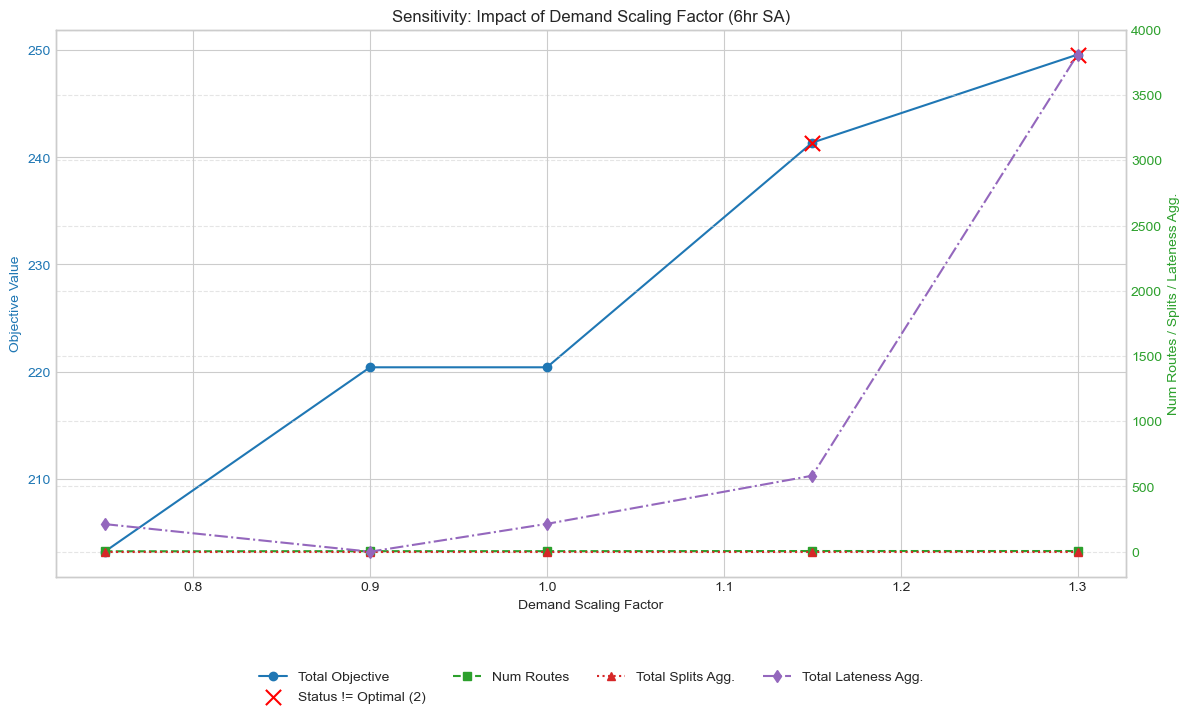

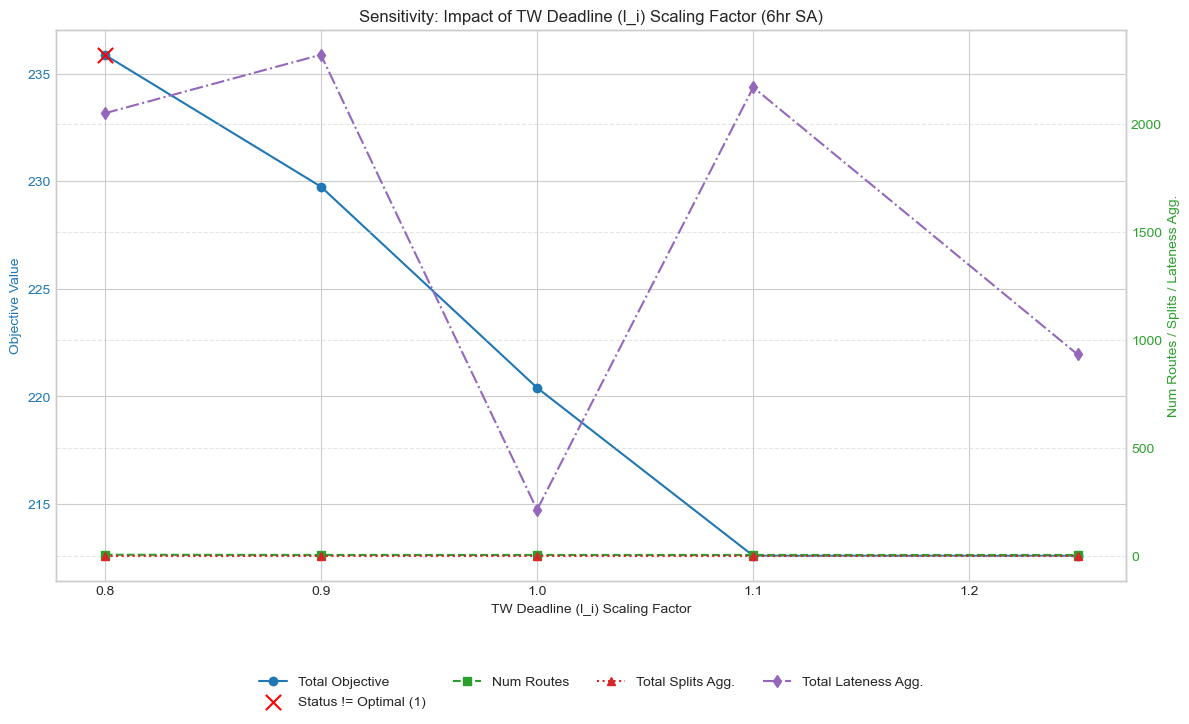


Generating OWSA cost component plots (6hr SA)...


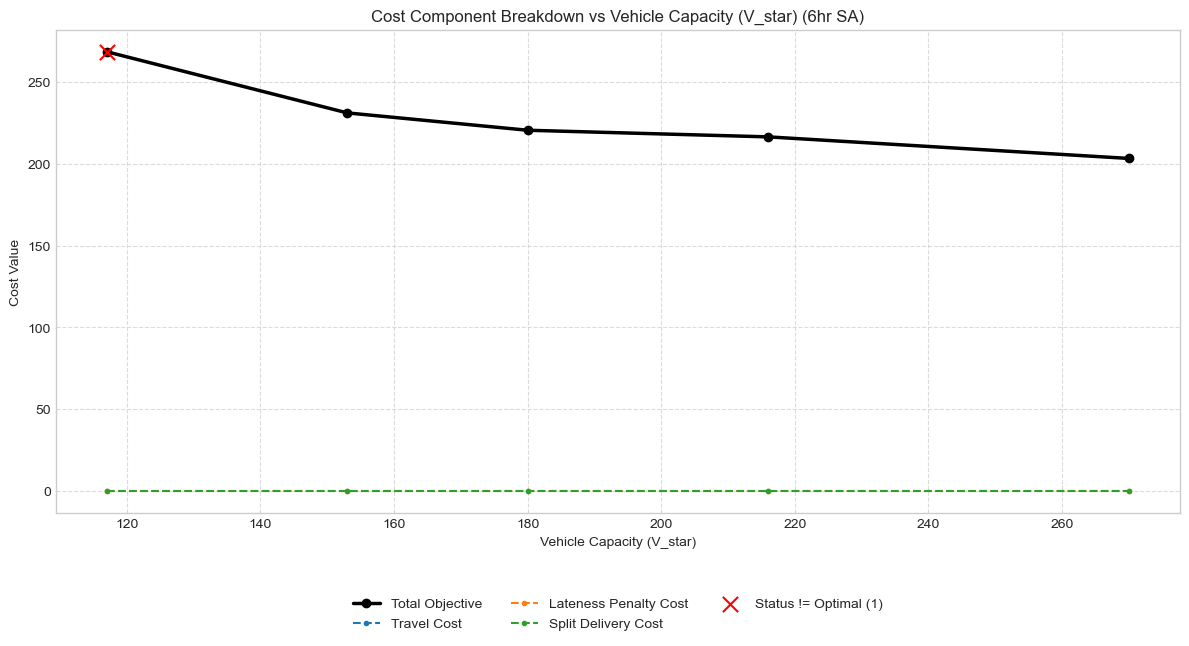

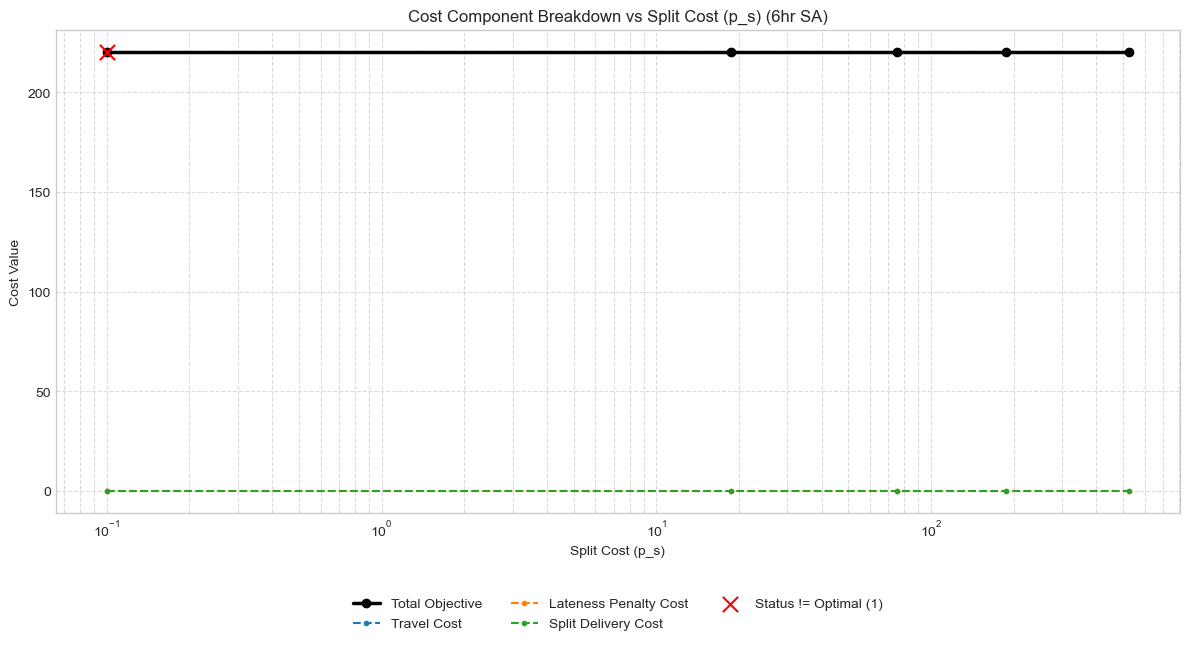

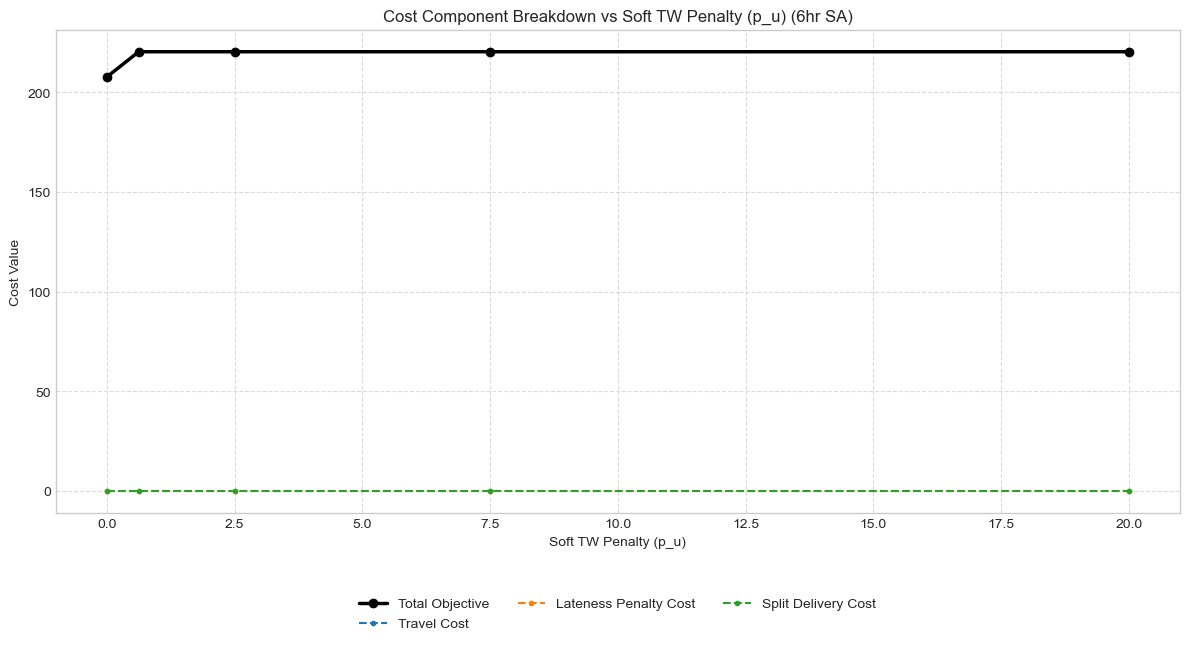

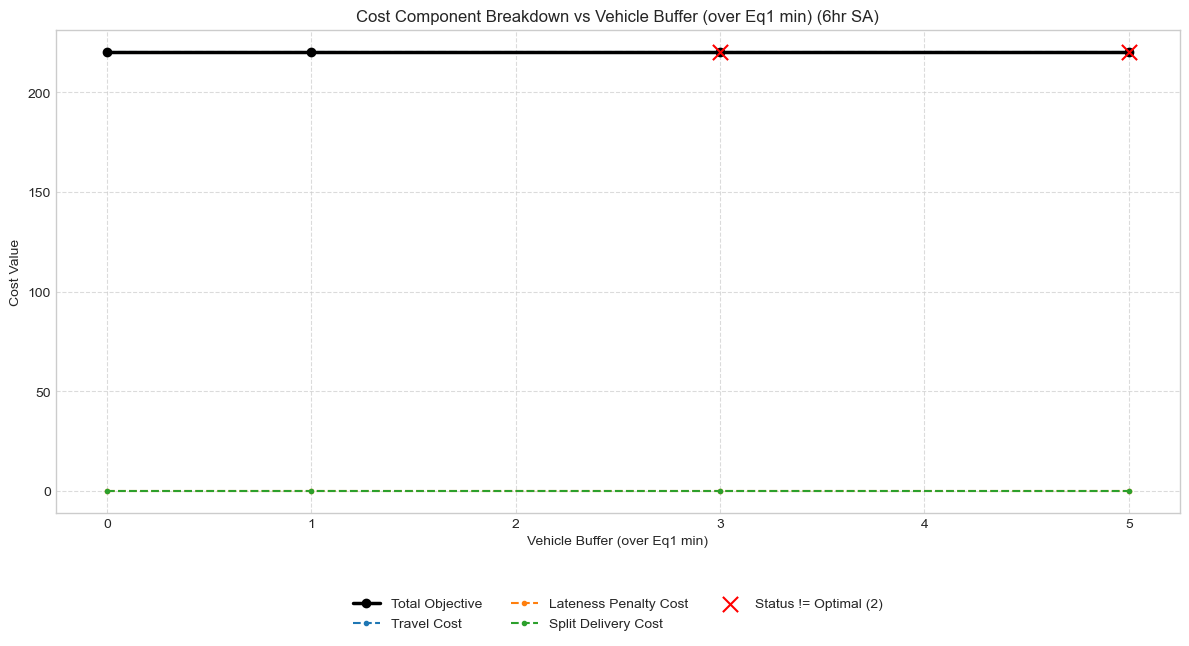

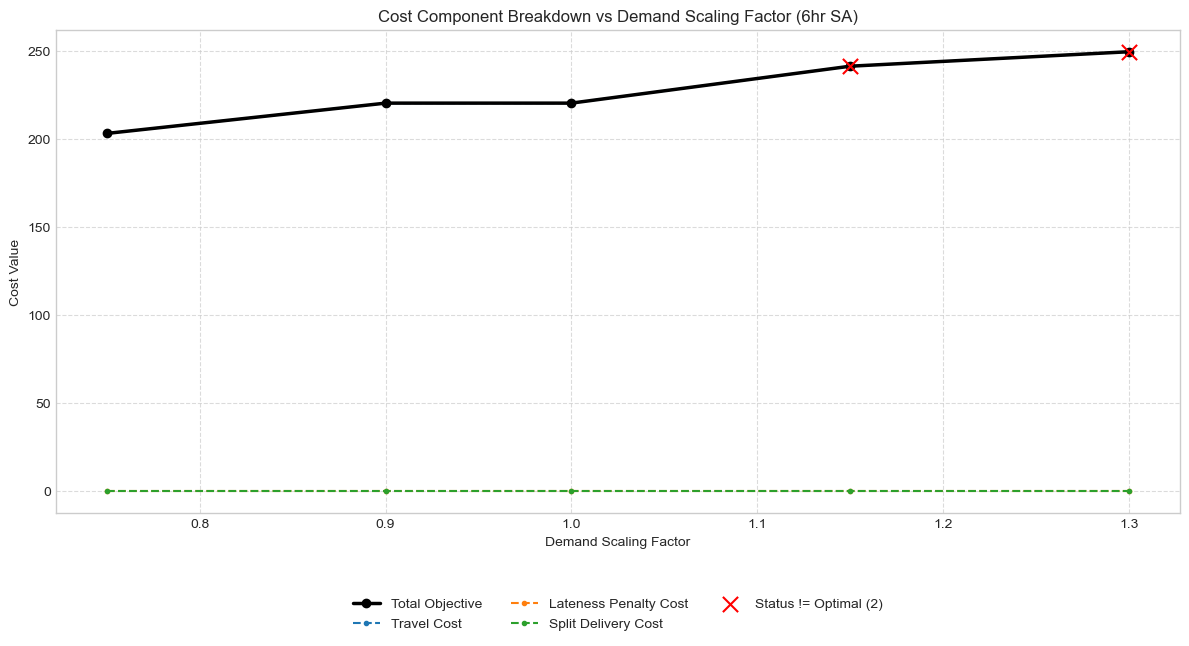

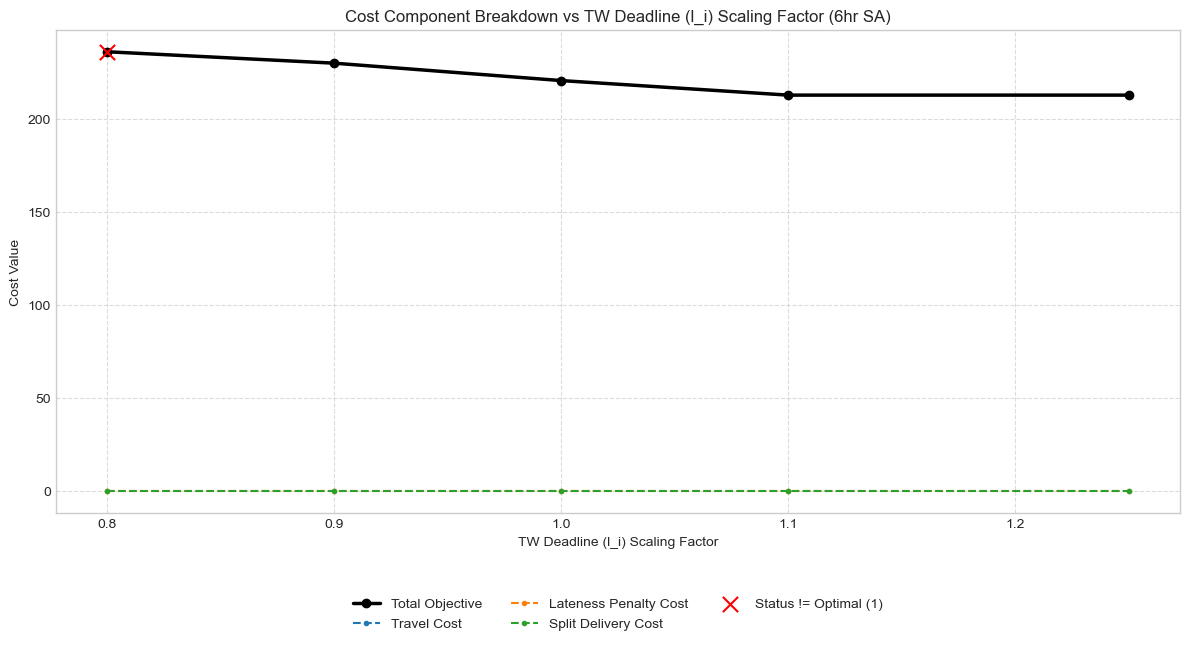


Generating TWSA heatmap plots (6hr SA)...
TWSA 'parameter_value' is not a tuple of two values for V_star. Cannot create heatmap directly.

Generating runtime plots (6hr SA)...


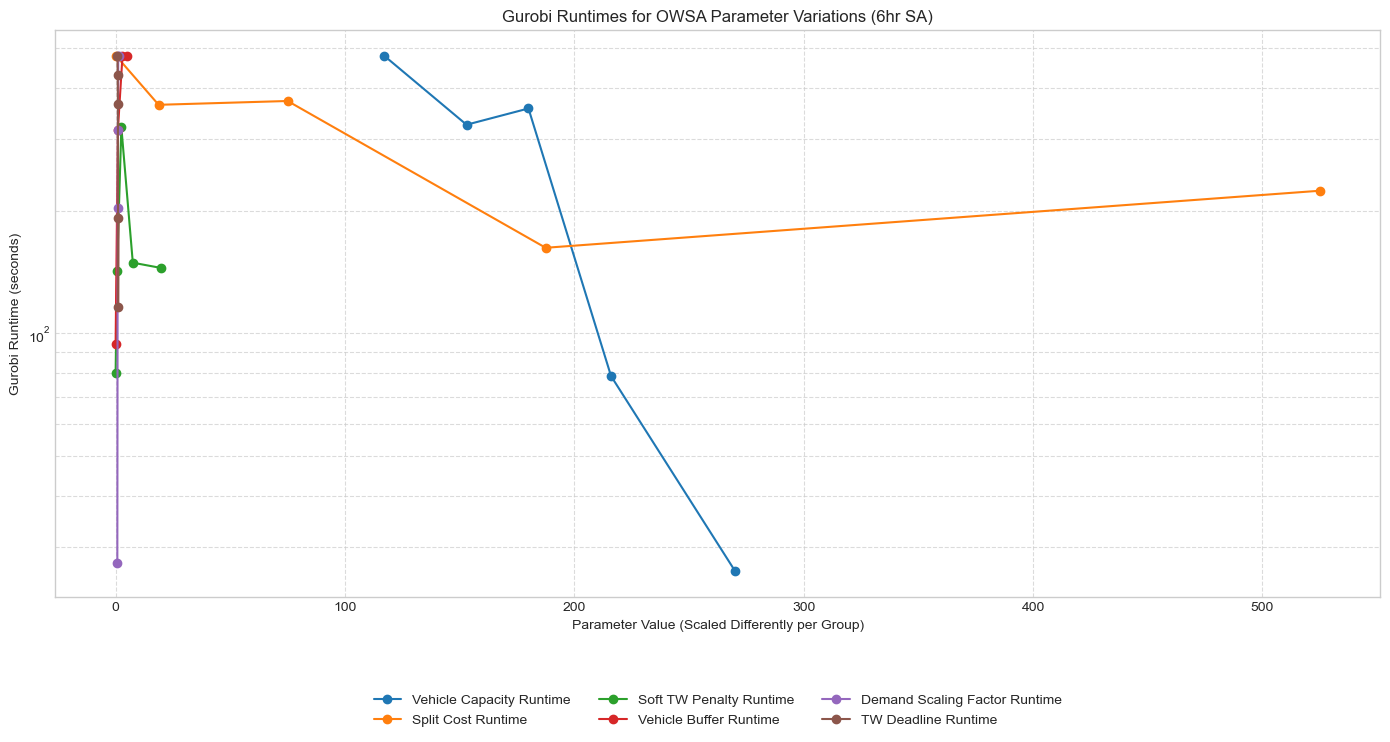


Plot generation complete for (6hr SA).

--- End of Plotting (Block 6) ---


In [10]:
# Block 6: Plotting Sensitivity Analysis Results from Saved CSV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For heatmaps

print("\n--- Block 6: Plotting Sensitivity Analysis Results from CSV ---")

# --- Configuration: Specify the CSV file to load ---
# This should be the CSV file saved by your Block 5 run.
# Examples:
# csv_to_load = "sensitivity_analysis_VRPOR_results_RAPID.csv"
csv_to_load = "sensitivity_analysis_VRPOR_results_6HR.csv"
# csv_to_load = "sensitivity_analysis_VRPOR_results_OVERNIGHT.csv"

df_to_plot = None
plot_label_suffix = "" # Will be set based on filename

try:
    df_to_plot = pd.read_csv(csv_to_load)
    print(f"Successfully loaded data from {csv_to_load}")
    # Determine label suffix based on filename
    if "RAPID" in csv_to_load.upper(): plot_label_suffix = "(Rapid SA)"
    elif "6HR" in csv_to_load.upper(): plot_label_suffix = "(6hr SA)"
    elif "OVERNIGHT" in csv_to_load.upper(): plot_label_suffix = "(Overnight SA)"
    else: plot_label_suffix = "(Loaded SA)"
except FileNotFoundError:
    print(f"Error: Could not find CSV file '{csv_to_load}'. Make sure Block 5 ran successfully and saved the file.")
except Exception as e:
    print(f"Error loading CSV file '{csv_to_load}': {e}")

# --- Plotting Function Definitions ---

def plot_owsa_results(df, param_group_name, x_axis_label, df_label=""):
    """Plots Objective, Routes, Splits, Lateness for OWSA."""
    # Filter for OWSA data (parameter_name usually contains only one varying param)
    # For TWSA, parameter_name is like "V_star=X, p_s=Y"
    df_group_all = df[df['analysis_param_group'] == param_group_name]
    # Further filter to ensure parameter_value is a single number (typical for OWSA)
    df_group = df_group_all[pd.to_numeric(df_group_all['parameter_value'], errors='coerce').notna()].copy()
    # Convert parameter_value to numeric for proper sorting/plotting if it was string
    df_group['parameter_value'] = pd.to_numeric(df_group['parameter_value'])
    df_group = df_group.sort_values(by='parameter_value').dropna(subset=['objective_value'])


    if df_group.empty:
        print(f"No valid OWSA data to plot for {param_group_name} {df_label}")
        return

    fig, ax1 = plt.subplots(figsize=(12, 7))
    color1 = 'tab:blue'
    ax1.set_xlabel(x_axis_label)
    ax1.set_ylabel('Objective Value', color=color1)
    ax1.plot(df_group['parameter_value'], df_group['objective_value'], marker='o', linestyle='-', color=color1, label='Total Objective')
    ax1.tick_params(axis='y', labelcolor=color1)

    non_opt_df = df_group[df_group['status_message'] != "Optimal"]
    if not non_opt_df.empty:
        ax1.scatter(non_opt_df['parameter_value'], non_opt_df['objective_value'], marker='x', color='red', s=120, label=f'Status != Optimal ({len(non_opt_df)})', zorder=5)

    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.set_ylabel('Num Routes / Splits / Lateness Agg.', color=color2)
    ax2.plot(df_group['parameter_value'], df_group['num_routes'], marker='s', linestyle='--', color=color2, label='Num Routes')
    ax2.plot(df_group['parameter_value'], df_group['total_split_extra_visits_agg'], marker='^', linestyle=':', color='tab:red', label='Total Splits Agg.')
    ax2.plot(df_group['parameter_value'], df_group['total_lateness_value_agg'], marker='d', linestyle='-.', color='tab:purple', label='Total Lateness Agg.')
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout(rect=[0, 0.05, 1, 0.93]) # Adjust for title
    plt.title(f'Sensitivity: Impact of {x_axis_label} {df_label}')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=min(len(labels + labels2), 4))
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()

def plot_cost_components_owsa(df, param_group_name, x_axis_label, df_label=""):
    """Plots Objective and its cost components for OWSA."""
    df_group_all = df[df['analysis_param_group'] == param_group_name]
    df_group = df_group_all[pd.to_numeric(df_group_all['parameter_value'], errors='coerce').notna()].copy()
    df_group['parameter_value'] = pd.to_numeric(df_group['parameter_value'])
    df_group = df_group.sort_values(by='parameter_value').dropna(subset=['objective_value'])

    if df_group.empty:
        print(f"No valid cost component data to plot for {param_group_name} {df_label}")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(df_group['parameter_value'], df_group['objective_value'], marker='o', linestyle='-', color='black', linewidth=2.5, label='Total Objective', zorder=10)
    plt.plot(df_group['parameter_value'], df_group['cost_travel'].fillna(0), marker='.', linestyle='--', label='Travel Cost')
    plt.plot(df_group['parameter_value'], df_group['cost_penalty_lateness'].fillna(0), marker='.', linestyle='--', label='Lateness Penalty Cost')
    plt.plot(df_group['parameter_value'], df_group['cost_split_delivery'].fillna(0), marker='.', linestyle='--', label='Split Delivery Cost')

    non_opt_df = df_group[df_group['status_message'] != "Optimal"]
    if not non_opt_df.empty:
        plt.scatter(non_opt_df['parameter_value'], non_opt_df['objective_value'], marker='x', color='red', s=120, label=f'Status != Optimal ({len(non_opt_df)})', zorder=15)

    plt.xlabel(x_axis_label)
    plt.ylabel("Cost Value")
    plt.title(f'Cost Component Breakdown vs {x_axis_label} {df_label}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    # Auto log scale for x-axis if parameter values span orders of magnitude and are positive
    min_val_x = df_group['parameter_value'].min()
    max_val_x = df_group['parameter_value'].max()
    if min_val_x > 0 and max_val_x / min_val_x > 20 : # Heuristic for log scale
        plt.xscale('log')
    plt.show()

def plot_twsa_heatmap(df, param_group_prefix, param1_name_in_df, param2_name_in_df, param1_label, param2_label, df_label=""):
    """Plots a heatmap for TWSA results (Objective Value)."""
    # TWSA data has parameter_name like "V_star=X, p_s=Y"
    # The analysis_param_group should be the prefix, e.g., "V_star" if the first param in name is V_star
    df_twsa = df[df['analysis_param_group'] == param_group_prefix].copy()

    if df_twsa.empty:
        print(f"No TWSA data found for group prefix '{param_group_prefix}' {df_label}")
        return

    # Extract the two parameter values from 'parameter_value' or 'parameter_name'
    # Assuming 'parameter_value' for TWSA is a tuple (val1, val2)
    # If it's a string like "V_star=X, p_s=Y", parsing is needed.
    # Let's assume 'parameter_value' is the tuple (val1, val2) from the run_and_record call
    if not (isinstance(df_twsa['parameter_value'].iloc[0], tuple) and len(df_twsa['parameter_value'].iloc[0]) == 2):
        print(f"TWSA 'parameter_value' is not a tuple of two values for {param_group_prefix}. Cannot create heatmap directly.")
        # Attempt to parse from parameter_name if needed (more complex)
        # Example parsing (adjust based on actual 'parameter_name' format for TWSA):
        # def parse_twsa_params(name_str):
        # try:
        # parts = name_str.split(',')
        # val1 = float(parts[0].split('=')[1])
        # val2 = float(parts[1].split('=')[1])
        # return val1, val2
        # except: return np.nan, np.nan
        # df_twsa[['param1_val', 'param2_val']] = df_twsa['parameter_name'].apply(lambda x: pd.Series(parse_twsa_params(x)))
        return


    df_twsa[['param1_val', 'param2_val']] = pd.DataFrame(df_twsa['parameter_value'].tolist(), index=df_twsa.index)

    try:
        pivot_table = df_twsa.pivot_table(values='objective_value', index='param1_val', columns='param2_val')
    except Exception as e:
        print(f"Could not create pivot table for heatmap for {param_group_prefix}: {e}")
        print("Check data structure and uniqueness of (param1_val, param2_val) combinations.")
        return

    if pivot_table.empty:
        print(f"Pivot table for heatmap is empty for {param_group_prefix} {df_label}")
        return

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="viridis_r", linewidths=.5) # _r reverses colormap
    plt.xlabel(param2_label)
    plt.ylabel(param1_label)
    plt.title(f'TWSA: Objective Value Heatmap\n({param1_label} vs {param2_label}) {df_label}')
    plt.tight_layout()
    plt.show()

def plot_runtimes_owsa(df, df_label=""):
    """Plots Gurobi runtimes for different OWSA parameter groups."""
    plt.figure(figsize=(14, 8))
    owsa_groups = df[pd.to_numeric(df['parameter_value'], errors='coerce').notna()]['analysis_param_group'].unique()

    for group_name in owsa_groups:
        df_group = df[df['analysis_param_group'] == group_name].copy()
        df_group['parameter_value'] = pd.to_numeric(df_group['parameter_value'])
        df_group = df_group.sort_values(by='parameter_value')
        if not df_group.empty:
            plt.plot(df_group['parameter_value'], df_group['gurobi_runtime'], marker='o', linestyle='-', label=f'{group_name} Runtime')

    plt.xlabel('Parameter Value (Scaled Differently per Group)')
    plt.ylabel('Gurobi Runtime (seconds)')
    plt.title(f'Gurobi Runtimes for OWSA Parameter Variations {df_label}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    # Using log scale for runtime often makes sense due to wide variations
    plt.yscale('log')
    # X-axis cannot be log if parameter values include 0 or negative, or span too differently.
    # Consider plotting each group on a separate subplot if x-axis scales are too different.
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


# --- Generate Plots if Data was Loaded ---
if df_to_plot is not None and not df_to_plot.empty:
    plt.style.use('seaborn-v0_8-whitegrid') # Ensure style is set

    print(f"\nGenerating OWSA summary plots {plot_label_suffix}...")
    owsa_param_groups = {
        "Vehicle Capacity": "Vehicle Capacity (V_star)",
        "Split Cost": "Split Cost (p_s)",
        "Soft TW Penalty": "Soft TW Penalty (p_u)",
        "Vehicle Buffer": "Vehicle Buffer (over Eq1 min)",
        "Demand Scaling Factor": "Demand Scaling Factor",
        "TW Deadline": "TW Deadline (l_i) Scaling Factor"
    }
    for group_key, x_label in owsa_param_groups.items():
        plot_owsa_results(df_to_plot, group_key, x_label, df_label=plot_label_suffix)

    print(f"\nGenerating OWSA cost component plots {plot_label_suffix}...")
    for group_key, x_label in owsa_param_groups.items():
        plot_cost_components_owsa(df_to_plot, group_key, x_label, df_label=plot_label_suffix)

    # Plotting TWSA results (example for V_star vs p_s)
    # The 'analysis_param_group' for TWSA in the data is the name of the first parameter.
    # The 'parameter_name' contains both, e.g., "V_star=X, p_s=Y"
    # The 'parameter_value' is the tuple (X,Y)
    print(f"\nGenerating TWSA heatmap plots {plot_label_suffix}...")
    # Assuming your TWSA run with V_star and p_s used "Vehicle Capacity" as the analysis_param_group for its records
    # (because V_star was the first param in the name like "V_star=X, p_s=Y")
    # You might need to adjust the group name if it's different.
    # Or, filter based on 'parameter_name' containing commas.
    df_twsa_vstar_ps = df_to_plot[df_to_plot['parameter_name'].str.contains('V_star=.*, p_s=.*', na=False, regex=True)]
    if not df_twsa_vstar_ps.empty:
         plot_twsa_heatmap(df_twsa_vstar_ps, df_twsa_vstar_ps['analysis_param_group'].iloc[0] , # Use first group name found
                           "V_star_val", "p_s_val", # Placeholder, actual parsing from tuple
                           "Vehicle Capacity (V_star)", "Split Cost (p_s)", df_label=plot_label_suffix)
    else:
        print("No specific TWSA data found for V_star vs p_s to plot heatmap.")

    # Add more TWSA plot calls if you ran other combinations, e.g.:
    # df_twsa_pu_tw = df_to_plot[df_to_plot['parameter_name'].str.contains('p_u=.*, TWScale=.*', na=False, regex=True)]
    # if not df_twsa_pu_tw.empty:
    #      plot_twsa_heatmap(df_twsa_pu_tw, df_twsa_pu_tw['analysis_param_group'].iloc[0],
    #                        "p_u_val", "tw_scale_val",
    #                        "Soft TW Penalty (p_u)", "TW Scale Factor", df_label=plot_label_suffix)

    print(f"\nGenerating runtime plots {plot_label_suffix}...")
    plot_runtimes_owsa(df_to_plot, df_label=plot_label_suffix)

    print(f"\nPlot generation complete for {plot_label_suffix.strip()}.")
else:
    print("Skipping plot generation as no data was loaded or DataFrame is empty.")

print("\n--- End of Plotting (Block 6) ---")


--- Block 7: Pseudo-Global Sensitivity Insights (Tornado Plot from LSA Data) ---
Note: This block uses existing LSA data. True GSA requires different sampling.
Successfully loaded data from sensitivity_analysis_VRPOR_results_6HR.csv for GSA-like analysis.

Calculating sensitivity ranges for Tornado Plot (metric: objective_value):
  Vehicle Capacity (V_star): Output Range = 65.17 (Min: 203.18, Max: 268.35)
  Split Cost (p_s): Output Range = 0.00 (Min: 220.40, Max: 220.40)
  Soft TW Penalty (p_u): Output Range = 12.68 (Min: 207.72, Max: 220.40)
  Vehicle Buffer (Vehicle Min Time): Output Range = 0.00 (Min: 220.40, Max: 220.40)
  Demand Scaling Factor: Output Range = 46.41 (Min: 203.18, Max: 249.59)
  TW Deadline (l_i) Scaling Factor: Output Range = 23.29 (Min: 212.59, Max: 235.88)


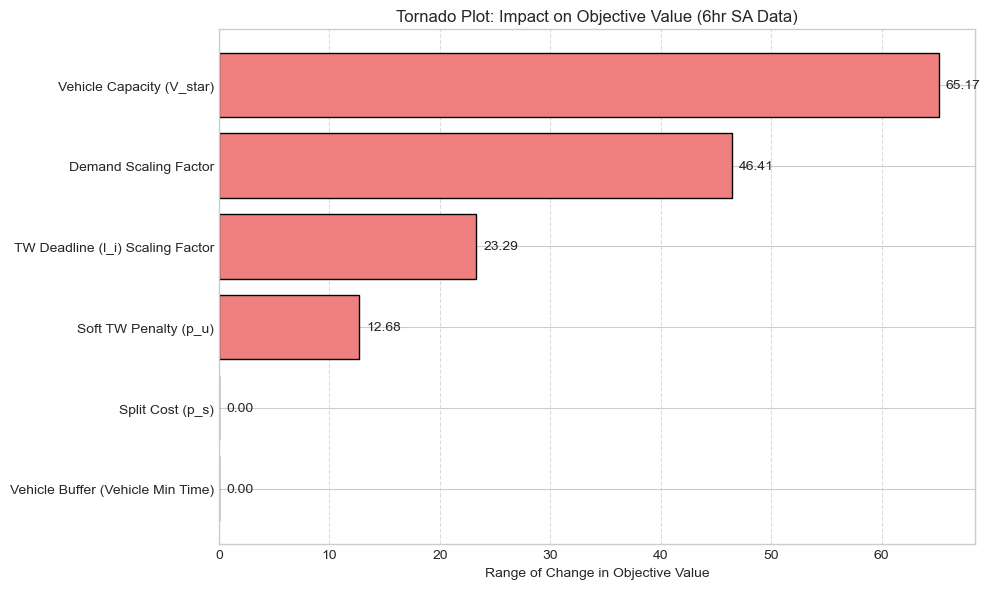

Tornado plot generated for objective_value (6hr SA Data)

--- End of Pseudo-Global Sensitivity Insights (Block 7) ---


In [5]:
# Block 7: "Pseudo" Global Sensitivity Insights - Tornado Plot from LSA Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For styling, though not strictly necessary for tornado

print("\n--- Block 7: Pseudo-Global Sensitivity Insights (Tornado Plot from LSA Data) ---")
print("Note: This block uses existing LSA data. True GSA requires different sampling.")

# --- Configuration: Specify the CSV file to load ---
csv_to_load = "sensitivity_analysis_VRPOR_results_6HR.csv"
# ... (other CSV options) ...

df_analysis_data = None
plot_label_suffix_gsa = ""

try:
    df_analysis_data = pd.read_csv(csv_to_load)
    print(f"Successfully loaded data from {csv_to_load} for GSA-like analysis.")
    if "RAPID" in csv_to_load.upper(): plot_label_suffix_gsa = "(Rapid SA Data)"
    elif "6HR" in csv_to_load.upper(): plot_label_suffix_gsa = "(6hr SA Data)"
    elif "OVERNIGHT" in csv_to_load.upper(): plot_label_suffix_gsa = "(Overnight SA Data)"
    else: plot_label_suffix_gsa = "(Loaded SA Data)"
except FileNotFoundError:
    print(f"Error: Could not find CSV file '{csv_to_load}'. Make sure Block 5 ran and saved the file.")
    df_analysis_data = pd.DataFrame() # Ensure it's an empty df, not None
except Exception as e:
    print(f"Error loading CSV file '{csv_to_load}': {e}")
    df_analysis_data = pd.DataFrame() # Ensure it's an empty df, not None

# --- Tornado Plot Function ---

def plot_tornado_from_owsa(df, owsa_param_groups_dict, output_metric_col='objective_value', df_label=""):
    """
    Generates a Tornado Plot from OWSA results.
    """
    if df is None or df.empty:
        print(f"No data provided or DataFrame is empty for Tornado plot {df_label}.")
        return

    sensitivity_ranges = []
    print(f"\nCalculating sensitivity ranges for Tornado Plot (metric: {output_metric_col}):")

    for param_group_key, param_display_name in owsa_param_groups_dict.items():
        df_param_group = df[df['analysis_param_group'] == param_group_key].copy()

        df_param_group['parameter_value_numeric'] = pd.to_numeric(df_param_group['parameter_value'], errors='coerce')
        
        # Ensure output_metric_col exists before using it in dropna
        if output_metric_col not in df_param_group.columns:
            print(f"  Warning: Output metric column '{output_metric_col}' not found for parameter group '{param_group_key}'. Skipping.")
            continue
            
        df_param_group.dropna(subset=['parameter_value_numeric', output_metric_col], inplace=True)

        if df_param_group.empty:
            print(f"  No valid OWSA data for parameter group: '{param_group_key}' after filtering/dropna.")
            continue

        # --- Robust handling of optional baseline run ---
        nominal_output = None # Initialize
        # Check if 'is_baseline_run' column exists and is boolean
        if 'is_baseline_run' in df_param_group.columns and pd.api.types.is_bool_dtype(df_param_group['is_baseline_run']):
            baseline_run_df = df_param_group[df_param_group['is_baseline_run']] # Filter using the boolean column
            if not baseline_run_df.empty:
                if output_metric_col in baseline_run_df.columns:
                    # Take the first baseline run's output if multiple exist
                    nominal_output = baseline_run_df[output_metric_col].iloc[0]
                else:
                    # This case should be rare if output_metric_col check passed for df_param_group
                    print(f"  Warning: Baseline run(s) found for '{param_group_key}', but output metric '{output_metric_col}' not in baseline_run_df columns.")
        elif 'is_baseline_run' in df_param_group.columns:
            print(f"  Warning: 'is_baseline_run' column exists for '{param_group_key}' but is not boolean type. Skipping baseline detection.")
        # If 'is_baseline_run' does not exist, nominal_output remains None (no error, no warning here)
        # --- End of baseline handling ---

        # Ensure output_metric_col still exists and is not empty after all operations
        if output_metric_col not in df_param_group.columns or df_param_group[output_metric_col].empty:
            print(f"  Warning: Output metric '{output_metric_col}' became unavailable or empty for '{param_group_key}' before min/max. Skipping.")
            continue
            
        min_output = df_param_group[output_metric_col].min()
        max_output = df_param_group[output_metric_col].max()
        output_range = max_output - min_output

        if pd.notna(output_range) and output_range >= 0: # Allow zero range if min=max
            sensitivity_ranges.append({
                'parameter': param_display_name,
                'output_min': min_output,
                'output_max': max_output,
                'range': output_range
                # 'nominal_output': nominal_output # Store if needed for more advanced tornado
            })
            print(f"  {param_display_name}: Output Range = {output_range:.2f} (Min: {min_output:.2f}, Max: {max_output:.2f})")
        else:
            print(f"  {param_display_name}: No significant output variation or NaN data for range calculation.")

    if not sensitivity_ranges:
        print("No sensitivity ranges calculated (all parameters might have had issues or no variation). Cannot generate Tornado Plot.")
        return

    sorted_sensitivities = sorted(sensitivity_ranges, key=lambda x: x['range'], reverse=True)
    param_names = [s['parameter'] for s in sorted_sensitivities]
    ranges = [s['range'] for s in sorted_sensitivities]
    
    num_params = len(param_names)
    if num_params == 0:
        print("No parameters with valid ranges to plot.")
        return
        
    y_pos = np.arange(num_params)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, max(6, num_params * 0.6))) # Adjusted height factor

    bars = ax.barh(y_pos, ranges, align='center', color='lightcoral', edgecolor='black') # Changed color
    ax.set_yticks(y_pos)
    ax.set_yticklabels(param_names)
    ax.invert_yaxis()
    ax.set_xlabel(f'Range of Change in {output_metric_col.replace("_", " ").title()}')
    ax.set_title(f'Tornado Plot: Impact on {output_metric_col.replace("_", " ").title()} {df_label}')

    max_range_val = max(ranges) if ranges else 1 # Avoid division by zero if ranges is empty
    for i, bar in enumerate(bars):
        width = bar.get_width()
        # Adjust text position to be more robust, especially for zero-width bars
        text_x_pos = width + (0.01 * max_range_val) if width > 0 else (0.01 * max_range_val)
        if width == 0 and max_range_val == 0 : text_x_pos = 0.01 # Handle all zero case

        ax.text(text_x_pos,
                bar.get_y() + bar.get_height()/2,
                f'{ranges[i]:.2f}',
                va='center', ha='left')
    
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print(f"Tornado plot generated for {output_metric_col} {df_label}")


# --- Execute Plotting for Block 7 ---
if df_analysis_data is not None and not df_analysis_data.empty:
    owsa_param_groups_for_tornado = {
        "Vehicle Capacity": "Vehicle Capacity (V_star)",
        "Split Cost": "Split Cost (p_s)",
        "Soft TW Penalty": "Soft TW Penalty (p_u)",
        "Vehicle Buffer": "Vehicle Buffer (Vehicle Min Time)",
        "Demand Scaling Factor": "Demand Scaling Factor",
        "TW Deadline": "TW Deadline (l_i) Scaling Factor"
    }

    plot_tornado_from_owsa(df_analysis_data,
                           owsa_param_groups_for_tornado,
                           output_metric_col='objective_value',
                           df_label=plot_label_suffix_gsa)
else:
    print("Skipping Tornado plot generation as no data was loaded or DataFrame is empty.")

print("\n--- End of Pseudo-Global Sensitivity Insights (Block 7) ---")


--- Block 8: Comprehensive Sensitivity Summary Heatmap ---
Note: This block uses existing LSA data to summarize impacts across multiple metrics.
Successfully loaded data from sensitivity_analysis_VRPOR_results_6HR.csv for summary heatmap.

Calculating sensitivity ranges for Summary Heatmap:


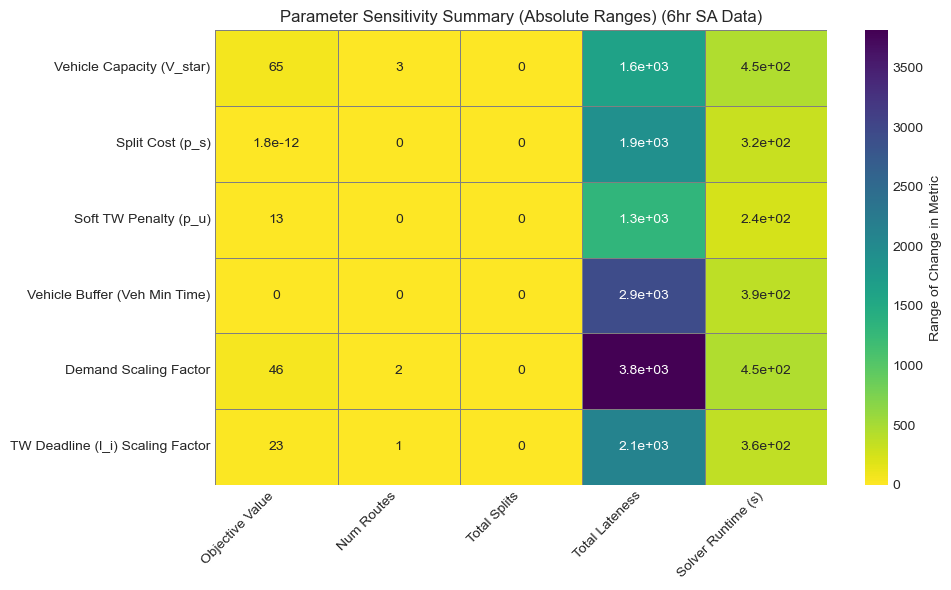

Summary heatmap generated.

Calculating sensitivity ranges for Summary Heatmap:
Normalizing data by column (0-1 scaling for each metric's impact range).


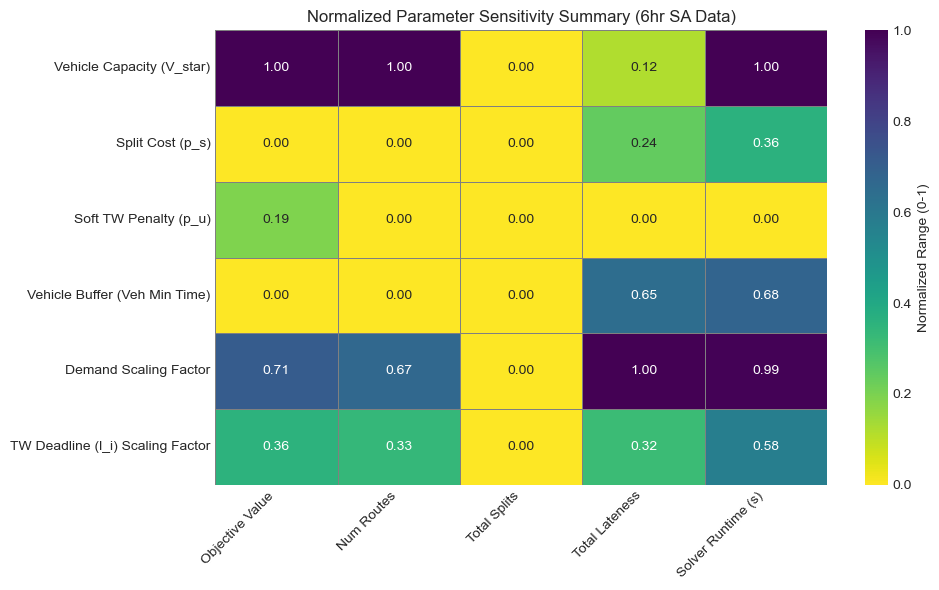

Summary heatmap generated.

--- End of Comprehensive Sensitivity Summary Heatmap (Block 8) ---


In [4]:
# Block 8: Comprehensive Sensitivity Summary Heatmap from LSA Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Block 8: Comprehensive Sensitivity Summary Heatmap ---")
print("Note: This block uses existing LSA data to summarize impacts across multiple metrics.")

# --- Configuration: Specify the CSV file to load ---
# This should be the CSV file saved by your Block 5 run.
csv_to_load = "sensitivity_analysis_VRPOR_results_6HR.csv"
# csv_to_load = "sensitivity_analysis_VRPOR_results_RAPID.csv"
# csv_to_load = "sensitivity_analysis_VRPOR_results_OVERNIGHT.csv"

df_analysis_data = None
plot_label_suffix_summary = ""

try:
    df_analysis_data = pd.read_csv(csv_to_load)
    print(f"Successfully loaded data from {csv_to_load} for summary heatmap.")
    if "RAPID" in csv_to_load.upper(): plot_label_suffix_summary = "(Rapid SA Data)"
    elif "6HR" in csv_to_load.upper(): plot_label_suffix_summary = "(6hr SA Data)"
    elif "OVERNIGHT" in csv_to_load.upper(): plot_label_suffix_summary = "(Overnight SA Data)"
    else: plot_label_suffix_summary = "(Loaded SA Data)"
except FileNotFoundError:
    print(f"Error: Could not find CSV file '{csv_to_load}'. Make sure Block 5 ran and saved the file.")
    df_analysis_data = pd.DataFrame() # Ensure it's an empty df, not None
except Exception as e:
    print(f"Error loading CSV file '{csv_to_load}': {e}")
    df_analysis_data = pd.DataFrame() # Ensure it's an empty df, not None

# --- Heatmap Plotting Function ---

def plot_sensitivity_summary_heatmap(df,
                                     owsa_param_groups_dict,
                                     metrics_to_summarize_dict,
                                     df_label="",
                                     normalize_by_column=False): # New parameter for normalization
    """
    Generates a heatmap summarizing the range of change for multiple metrics
    across multiple parameters from OWSA results.

    Args:
        df (pd.DataFrame): The DataFrame containing sensitivity analysis results.
        owsa_param_groups_dict (dict): Maps 'analysis_param_group' (CSV) to display names.
        metrics_to_summarize_dict (dict): Maps metric column names (CSV) to display names for plot.
        df_label (str): Label suffix for the plot title.
        normalize_by_column (bool): If True, normalizes ranges within each metric column (0-1 scaling).
    """
    if df is None or df.empty:
        print(f"No data provided or DataFrame is empty for summary heatmap {df_label}.")
        return

    summary_data = {}
    param_display_names_ordered = []

    print(f"\nCalculating sensitivity ranges for Summary Heatmap:")

    for param_group_key, param_display_name in owsa_param_groups_dict.items():
        df_param_group_full = df[df['analysis_param_group'] == param_group_key]

        # Ensure 'parameter_value' is numeric for OWSA single-parameter variations
        # This check is mainly to ensure we are dealing with OWSA data for this param group
        temp_numeric_param_values = pd.to_numeric(df_param_group_full['parameter_value'], errors='coerce')
        
        # Filter to include only rows where parameter_value was successfully converted to numeric
        # (characteristic of OWSA runs for this parameter)
        df_param_group = df_param_group_full[temp_numeric_param_values.notna()].copy()


        if df_param_group.empty:
            print(f"  No valid OWSA data (numeric parameter_value) for parameter group: '{param_group_key}'. Skipping.")
            continue
        
        param_display_names_ordered.append(param_display_name)
        summary_data[param_display_name] = {}

        for metric_col, metric_display_name in metrics_to_summarize_dict.items():
            if metric_col not in df_param_group.columns:
                print(f"  Metric column '{metric_col}' not found for parameter group '{param_group_key}'. Setting range to NaN.")
                summary_data[param_display_name][metric_display_name] = np.nan
                continue

            # Ensure the metric column itself doesn't have all NaNs for this parameter's OWSA runs
            if df_param_group[metric_col].isnull().all():
                print(f"  Metric column '{metric_col}' contains all NaNs for parameter group '{param_group_key}'. Setting range to NaN.")
                summary_data[param_display_name][metric_display_name] = np.nan
                continue
                
            min_metric = df_param_group[metric_col].min()
            max_metric = df_param_group[metric_col].max()
            metric_range = max_metric - min_metric

            if pd.notna(metric_range):
                summary_data[param_display_name][metric_display_name] = metric_range
                # print(f"    {param_display_name} vs {metric_display_name}: Range = {metric_range:.2f}")
            else:
                summary_data[param_display_name][metric_display_name] = np.nan # Handle cases where range can't be calculated

    if not summary_data:
        print("No summary data calculated. Cannot generate Heatmap.")
        return

    summary_df = pd.DataFrame.from_dict(summary_data, orient='index')
    # Reorder rows to match the order in owsa_param_groups_dict if some params were skipped
    summary_df = summary_df.reindex(param_display_names_ordered)
    # Reorder columns to match the order in metrics_to_summarize_dict
    summary_df = summary_df[[metrics_to_summarize_dict[mc] for mc in metrics_to_summarize_dict.keys() if metrics_to_summarize_dict[mc] in summary_df.columns]]


    if summary_df.empty:
        print("Summary DataFrame is empty. Cannot generate Heatmap.")
        return

    # --- Optional Normalization ---
    if normalize_by_column:
        print("Normalizing data by column (0-1 scaling for each metric's impact range).")
        # Handle columns that are all NaN or all same value (range 0) before normalization
        for col in summary_df.columns:
            min_val = summary_df[col].min()
            max_val = summary_df[col].max()
            if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val: # All NaN or all same value
                if min_val == max_val and not pd.isna(min_val) : # all same non-NaN value (range is 0)
                     summary_df[col] = 0.0 # All values become 0 after normalization
                else: # all NaN
                    summary_df[col] = np.nan # Keep as NaN
            else:
                summary_df[col] = (summary_df[col] - min_val) / (max_val - min_val)
        plot_title = f'Normalized Parameter Sensitivity Summary {df_label}'
        annot_fmt = ".2f" # Format for normalized values
    else:
        plot_title = f'Parameter Sensitivity Summary (Absolute Ranges) {df_label}'
        annot_fmt = ".2g" # General format for absolute values, handles various scales

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(max(10, len(metrics_to_summarize_dict) * 1.8), # Wider if many metrics
                       max(6, len(owsa_param_groups_dict) * 0.8)))   # Taller if many params
    
    sns.heatmap(summary_df,
                annot=True,
                fmt=annot_fmt,
                cmap="viridis_r", # Or "coolwarm", "magma_r", etc. _r reverses.
                linewidths=.5,
                linecolor='gray',
                cbar_kws={'label': 'Range of Change in Metric' if not normalize_by_column else 'Normalized Range (0-1)'})
    
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.title(plot_title)
    plt.tight_layout()
    plt.show()
    print("Summary heatmap generated.")


# --- Execute Plotting for Block 8 ---
if df_analysis_data is not None and not df_analysis_data.empty:
    # Define the parameter groups (rows of heatmap)
    # Keys: 'analysis_param_group' from CSV. Values: Display names for plot.
    owsa_parameters_for_summary = {
        "Vehicle Capacity": "Vehicle Capacity (V_star)",
        "Split Cost": "Split Cost (p_s)",
        "Soft TW Penalty": "Soft TW Penalty (p_u)",
        "Vehicle Buffer": "Vehicle Buffer (Veh Min Time)",
        "Demand Scaling Factor": "Demand Scaling Factor",
        "TW Deadline": "TW Deadline (l_i) Scaling Factor"
    }

    # Define the output metrics (columns of heatmap)
    # Keys: Column names from CSV. Values: Display names for plot.
    metrics_for_summary_heatmap = {
        'objective_value': 'Objective Value',
        'num_routes': 'Num Routes',
        'total_split_extra_visits_agg': 'Total Splits',
        'total_lateness_value_agg': 'Total Lateness',
        'gurobi_runtime': 'Solver Runtime (s)' # Example: adding runtime
    }
    
    # Option 1: Plot with absolute ranges
    plot_sensitivity_summary_heatmap(df_analysis_data,
                                     owsa_parameters_for_summary,
                                     metrics_for_summary_heatmap,
                                     df_label=plot_label_suffix_summary,
                                     normalize_by_column=False) # Plot raw ranges

    # Option 2: Plot with normalized ranges (per metric column)
    # This can be useful if the absolute ranges of metrics are very different,
    # making it hard to see relative sensitivities in one colormap.
    plot_sensitivity_summary_heatmap(df_analysis_data,
                                     owsa_parameters_for_summary,
                                     metrics_for_summary_heatmap,
                                     df_label=plot_label_suffix_summary,
                                     normalize_by_column=True) # Plot normalized ranges

else:
    print("Skipping summary heatmap generation as no data was loaded or DataFrame is empty.")

print("\n--- End of Comprehensive Sensitivity Summary Heatmap (Block 8) ---")

Global sensitivity analysis


In [7]:
# Block 9: Global Sensitivity Analysis (Morris Method) - VRPOR Integrated

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from SALib.sample import morris as morris_sample
from SALib.analyze import morris as morris_analyze
import time
import os

# --- Import your VRPOR functions from Block 1 ---
# Assuming Block 1 code (generate_instance_table2_final, solve_vrpor_table2_final, etc.)
# is in the same notebook/script or properly imported.
# If it's in this same notebook, just ensure it has been run.
# from your_block1_script import generate_instance_table2_final, solve_vrpor_table2_final # If in separate file

print("\n--- Block 9: Global Sensitivity Analysis (Morris Method) for VRPOR ---")

# --- 1. GSA Configuration ---

# Define the parameters for GSA and their bounds [min, max]
# Keys MUST match arguments of `generate_instance_table2_final` that you want to vary.
parameters_for_gsa_to_vary = {
    # Param Name in generate_instance: [min_value, max_value]
    'vehicle_capacity_V_star': [50, 250],    # V_star
    'penalty_pu_param':        [1.0, 20.0],  # p_u
    'split_ps_param':          [100, 2000],  # p_s
    'vehicle_buffer':          [0, 3],       # Integer, extra vehicles over min
    # Add other numerical parameters from generate_instance_table2_final if desired
    # e.g., if you had a global demand scaling factor or TW scaling factor as input to generate_instance
}
num_params_varying = len(parameters_for_gsa_to_vary)
param_names_varying_ordered = list(parameters_for_gsa_to_vary.keys())

# Fixed base parameters for generate_instance_table2_final
# These will NOT be varied by GSA but are needed to create an instance.
# Adjust these to your desired baseline scenario.
base_instance_generation_params = {
    "num_stores": 5,
    "num_physical_satellites": 2,
    "num_products": 3,
    "num_orders": 2,
    "seed": 42 # Keep seed fixed for GSA runs unless 'seed' itself is a sensitivity parameter
    # vehicle_capacity_V_star, penalty_pu_param, split_ps_param, vehicle_buffer
    # will be overridden by GSA samples.
}

# Morris method parameters
N_morris = 10  # Number of trajectories. Total runs = N * (D_varying+1).
              # D_varying=4, N=10 -> 10 * 5 = 50 runs.
              # Adjust N based on VRP run time.
num_levels_morris = 4

# Define the outputs to analyze from `solve_vrpor_table2_final` results
# These must be keys in the dictionary returned by `solve_vrpor_table2_final`
# or derivable from its 'objective_components'.
output_metrics_to_analyze = [
    'objective_value',
    'num_routes_actual', # Derived, see run_vrp_for_gsa
    'cost_travel',       # Derived
    'cost_penalty_lateness', # Derived
    'cost_split_delivery', # Derived
    'gurobi_runtime_actual' # From solve_time or runtime
]

# File to save GSA results
gsa_results_csv = "gsa_morris_vrpor_results.csv"
gsa_run_time_limit_seconds = 3600 # Max 1 hour for all GSA runs

# --- 2. Define the SALib Problem ---
problem_spec = {
    'num_vars': num_params_varying,
    'names': param_names_varying_ordered,
    'bounds': [parameters_for_gsa_to_vary[name] for name in param_names_varying_ordered]
}

# --- 3. Generate Parameter Samples (Morris) ---
print(f"Generating Morris samples: N={N_morris}, Levels={num_levels_morris}, D_varying={num_params_varying}")
try:
    param_values_morris = morris_sample.sample(problem_spec, N=N_morris, num_levels=num_levels_morris, optimal_trajectories=N_morris*2, local_optimization=True)
except Exception as e:
    print(f"Warning: Could not generate optimal trajectories, falling back. Error: {e}")
    param_values_morris = morris_sample.sample(problem_spec, N=N_morris, num_levels=num_levels_morris)
print(f"Generated {param_values_morris.shape[0]} parameter sets for GSA.")


# --- 4. VRP Model Execution Function ---
def run_vrp_for_gsa(sample_id, current_varying_params_dict):
    """
    Runs the VRPOR model with a given set of varying parameters.
    """
    print(f"\n--- Running VRPOR for GSA Sample {sample_id + 1} ---")

    # Combine base params with current GSA varying params
    instance_gen_args = base_instance_generation_params.copy()
    instance_gen_args.update(current_varying_params_dict)

    # Ensure integer params are int (like vehicle_buffer)
    if 'vehicle_buffer' in instance_gen_args:
        instance_gen_args['vehicle_buffer'] = int(round(instance_gen_args['vehicle_buffer']))

    print(f"Instance Gen Params: {instance_gen_args}")

    try:
        # 1. Generate instance
        instance_data = generate_instance_table2_final(**instance_gen_args)
        
        # 2. Solve VRPOR model
        # Adjust time_limit per run if needed, e.g. gsa_run_time_limit_seconds / num_total_samples
        # For simplicity, using a fixed moderate time limit per run here.
        solver_time_limit_per_run = 300 # 5 minutes per run, adjust as needed
        vrp_results = solve_vrpor_table2_final(instance_data,
                                               time_limit=solver_time_limit_per_run,
                                               mip_gap=0.01, # Slightly looser gap for GSA speed
                                               log_to_console=0)
        
        # 3. Extract results
        outputs = {}
        outputs['objective_value'] = vrp_results.get('objective_value', np.nan) # Main objective
        outputs['status_message'] = vrp_results.get('status_message', "SolverFunctionError")
        outputs['gurobi_runtime_actual'] = vrp_results.get('solve_time', np.nan) # Wall clock solve time

        if vrp_results.get('routes') is not None:
            outputs['num_routes_actual'] = len(vrp_results['routes'])
        else:
            outputs['num_routes_actual'] = np.nan # Or 0 if preferred for failed runs

        obj_comps = vrp_results.get('objective_components')
        if obj_comps:
            outputs['cost_travel'] = obj_comps.get('travel', np.nan)
            outputs['cost_penalty_lateness'] = obj_comps.get('penalty', np.nan)
            outputs['cost_split_delivery'] = obj_comps.get('split', np.nan)
        else:
            outputs['cost_travel'] = np.nan
            outputs['cost_penalty_lateness'] = np.nan
            outputs['cost_split_delivery'] = np.nan
        
        # Add all input parameters to the output for saving to CSV
        outputs.update(current_varying_params_dict)
        return outputs

    except Exception as e:
        print(f"MAJOR ERROR during VRPOR run for GSA sample {sample_id+1}: {e}")
        # Return NaNs for all metrics if a major error occurs in generation/solve
        failed_outputs = {metric: np.nan for metric in output_metrics_to_analyze}
        failed_outputs['status_message'] = f"OuterException: {str(e)[:100]}"
        failed_outputs.update(current_varying_params_dict) # Include params
        return failed_outputs

# --- 5. Execute Model Runs ---
model_outputs_for_salib = {metric: np.empty(param_values_morris.shape[0]) for metric in output_metrics_to_analyze}
all_run_details_for_csv = []

print(f"\nStarting VRPOR model evaluations for {param_values_morris.shape[0]} GSA samples...")
gsa_overall_start_time = time.time()

for i, X_sample_row in enumerate(param_values_morris):
    current_loop_start_time = time.time()
    # Check overall time limit
    if (current_loop_start_time - gsa_overall_start_time) > gsa_run_time_limit_seconds:
        print(f"GSA overall time limit of {gsa_run_time_limit_seconds}s reached. Stopping at sample {i+1}.")
        # Fill remaining SALib outputs with NaN if stopping early
        for metric_key in output_metrics_to_analyze:
            model_outputs_for_salib[metric_key][i:] = np.nan
        break # Exit the loop

    current_sample_varying_params = {name: X_sample_row[j] for j, name in enumerate(param_names_varying_ordered)}
    
    run_outputs_dict = run_vrp_for_gsa(i, current_sample_varying_params)
    all_run_details_for_csv.append(run_outputs_dict) # Store full dict for CSV

    for metric_key in output_metrics_to_analyze:
        model_outputs_for_salib[metric_key][i] = run_outputs_dict.get(metric_key, np.nan)
        
    if (i + 1) % 5 == 0 or (i + 1) == param_values_morris.shape[0]: # Print progress less frequently
        elapsed_total_gsa_time = time.time() - gsa_overall_start_time
        print(f"Completed GSA run {i + 1}/{param_values_morris.shape[0]}. Total GSA time: {elapsed_total_gsa_time:.2f}s.")
        if i > 0:
            avg_time_per_gsa_run = elapsed_total_gsa_time / (i + 1)
            runs_left = param_values_morris.shape[0] - (i + 1)
            estimated_time_left_gsa = runs_left * avg_time_per_gsa_run
            print(f"Avg time/GSA run: {avg_time_per_gsa_run:.2f}s. Est. GSA time remaining: {estimated_time_left_gsa:.2f}s.")

total_gsa_execution_time = time.time() - gsa_overall_start_time
print(f"\nAll GSA model evaluations (or time limit) finished. Total execution time: {total_gsa_execution_time:.2f}s")

# Save detailed GSA run data to CSV
if all_run_details_for_csv:
    df_gsa_details = pd.DataFrame(all_run_details_for_csv)
    # Order columns: input params first, then outputs
    cols_input_params = param_names_varying_ordered
    cols_outputs = [m for m in output_metrics_to_analyze if m in df_gsa_details.columns]
    # Add status if present
    if 'status_message' in df_gsa_details.columns:
        cols_outputs.append('status_message')
    
    final_cols_ordered = cols_input_params + [c for c in cols_outputs if c not in cols_input_params]
    # Add any other unexpected columns at the end
    final_cols_ordered.extend([col for col in df_gsa_details.columns if col not in final_cols_ordered])
    
    df_gsa_details = df_gsa_details[final_cols_ordered]
    df_gsa_details.to_csv(gsa_results_csv, index_label="gsa_sample_id")
    print(f"Detailed GSA run results saved to {gsa_results_csv}")
else:
    print("No GSA run details were collected to save.")


# --- 6. Perform Morris Analysis for Each Output Metric ---
morris_results_collection = {}
print("\n--- Performing Morris Analysis ---")
for metric_name_sa in output_metrics_to_analyze:
    Y_metric_values = model_outputs_for_salib[metric_name_sa]
    
    num_nans = np.sum(np.isnan(Y_metric_values))
    if num_nans > 0:
        print(f"Warning: Output '{metric_name_sa}' has {num_nans}/{len(Y_metric_values)} NaN values.")
        if num_nans == len(Y_metric_values):
            print(f"Skipping Morris analysis for '{metric_name_sa}' as all values are NaN.")
            morris_results_collection[metric_name_sa] = None
            continue
            
    # SALib Morris analysis expects no NaNs in Y.
    # If there are NaNs, it means some runs failed or were stopped.
    # We should analyze only the subset of X and Y where Y is not NaN.
    # This is complex because Morris trajectories rely on the full X.
    # For simplicity, SALib often errors out or gives unreliable results with NaNs.
    # A common practice is to impute NaNs or analyze only if NaNs are very few.
    # Here, we'll try and let SALib handle it / error out, then store None.
    try:
        if np.all(np.isnan(Y_metric_values)): # If all are NaN after early stop
             raise ValueError("All Y values are NaN, cannot analyze.")

        print(f"Analyzing Morris for: {metric_name_sa}")
        # Ensure Y is 1D for SALib
        Si_result = morris_analyze.analyze(problem_spec, param_values_morris, Y_metric_values.flatten(),
                                           conf_level=0.95, print_to_console=False,
                                           num_levels=num_levels_morris) # num_levels is important here
        morris_results_collection[metric_name_sa] = Si_result
        print(f"  Analysis complete for {metric_name_sa}.")
    except Exception as e_morris_analyze:
        print(f"  Error during Morris analysis for '{metric_name_sa}': {e_morris_analyze}")
        print("  This often happens if Y contains NaNs or if N is too small for num_levels.")
        morris_results_collection[metric_name_sa] = None

# --- 7. Plot Morris Analysis Results ---
plt.style.use('seaborn-v0_8-whitegrid')
print("\n--- Plotting Morris Results ---")

for metric_name_plot, Si_data in morris_results_collection.items():
    if Si_data is None:
        print(f"No Morris results to plot for metric: {metric_name_plot} (analysis likely failed or skipped).")
        continue

    mu_star_vals = Si_data['mu_star']
    sigma_vals = Si_data['sigma']

    fig, ax_scatter = plt.subplots(1, 1, figsize=(10, 7))
    ax_scatter.scatter(mu_star_vals, sigma_vals, s=60, c='darkorange', edgecolors='black', alpha=0.8)
    for i, txt_param_name in enumerate(param_names_varying_ordered):
        ax_scatter.annotate(txt_param_name, (mu_star_vals[i], sigma_vals[i]), textcoords="offset points", xytext=(5,5), ha='left')

    ax_scatter.set_xlabel(r'$\mu^*$ (Mean of Absolute Elementary Effects)')
    ax_scatter.set_ylabel(r'$\sigma$ (Std. Dev. of Elementary Effects)')
    ax_scatter.set_title(f'Morris Sensitivity for: {metric_name_plot.replace("_", " ").title()}')
    ax_scatter.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()
    print(f"Plotted Morris scatter (mu* vs sigma) for {metric_name_plot}.")

    # Bar chart for mu_star
    fig_bar, ax_bar_chart = plt.subplots(figsize=(10, 6))
    param_indices = np.arange(len(param_names_varying_ordered))
    bar_plot_colors = plt.cm.coolwarm(mu_star_vals / (max(mu_star_vals) if max(mu_star_vals) > 0 else 1.0) * 0.5 + 0.25) # Normalize for color
    
    ax_bar_chart.bar(param_indices, mu_star_vals, color=bar_plot_colors, edgecolor='black')
    ax_bar_chart.set_xticks(param_indices)
    ax_bar_chart.set_xticklabels(param_names_varying_ordered, rotation=45, ha="right")
    ax_bar_chart.set_ylabel(r'$\mu^*$ (Overall Importance)')
    ax_bar_chart.set_title(f'Parameter Importance ($\mu^*$) for: {metric_name_plot.replace("_", " ").title()}')
    plt.tight_layout()
    plt.show()
    print(f"Plotted Morris bar chart (mu*) for {metric_name_plot}.")

print("\n--- End of Global Sensitivity Analysis (Block 9) ---")


--- Block 9: Global Sensitivity Analysis (Morris Method) for VRPOR ---
Generating Morris samples: N=10, Levels=4, D_varying=4
Generated 50 parameter sets for GSA.

Starting VRPOR model evaluations for 50 GSA samples...

--- Running VRPOR for GSA Sample 1 ---
Instance Gen Params: {'num_stores': 5, 'num_physical_satellites': 2, 'num_products': 3, 'num_orders': 2, 'seed': 42, 'vehicle_capacity_V_star': np.float64(116.66666666666667), 'penalty_pu_param': np.float64(20.0), 'split_ps_param': np.float64(100.0), 'vehicle_buffer': 0}
MAJOR ERROR during VRPOR run for GSA sample 1: name 'generate_instance_table2_final' is not defined

--- Running VRPOR for GSA Sample 2 ---
Instance Gen Params: {'num_stores': 5, 'num_physical_satellites': 2, 'num_products': 3, 'num_orders': 2, 'seed': 42, 'vehicle_capacity_V_star': np.float64(116.66666666666667), 'penalty_pu_param': np.float64(7.333333333333334), 'split_ps_param': np.float64(100.0), 'vehicle_buffer': 0}
MAJOR ERROR during VRPOR run for GSA sample